# <span style='color:royalblue'> <u> The Effect of Feedback on Driver Behaviour </u> </span>
>#### <span style='color:midnightblue'> Author: Greg Carrigan </span>
#### <span style='color:midnightblue'> Thanks to Ian Davidson of GoFar for providing the data </span>

##### <span style='color:darkgreen'> <u>Notebook 2 of 2:</u> Statistical analysis, modelling, discussion and conclusion. </span>

##### <span style='color:darkgreen'> Part 1 can be found here:
https://git.generalassemb.ly/DSI-SYD-2/capstone_greg/blob/master/part-04/capstone_greg_part-04_intro_EDA.ipynb

## <span style='color:royalblue'> <u>Statistical Analysis </u></span>

#### <span style='color:midnightblue'> First, I'll import the main packages I'll need, plus the data from the original dataframe, 'drive', and the summarised one I created during the EDA, 'summ_trip'. </span>

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from pandas.io import sql
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
sqlite_db = 'C:/Users/gregc_000/Documents/GitHub/capstone_greg/drive.sqlite'
conn = sqlite3.connect(sqlite_db)

In [ ]:
# Note: To avoid accidentally writing over the database, I have commented out the commands below.

# drive.to_sql('go_far_data', con=conn, if_exists='replace', index=False)
# conn.close()

In [3]:
query = 'select * from go_far_data'
drive = sql.read_sql(query, con = conn)
conn.close()

In [4]:
sqlite_db_summ = 'C:/Users/gregc_000/Documents/GitHub/capstone_greg/summ_trip.sqlite'
conn2 = sqlite3.connect(sqlite_db_summ)

In [ ]:
# Note: To avoid accidentally writing over the database, I have commented out the commands below.

# summ_trip.to_sql('go_far_summ', con=conn2, if_exists='replace', index=False)
# conn.close()

In [5]:
query = 'select * from go_far_summ'
summ_trip = sql.read_sql(query, con = conn2)
conn2.close()

In [9]:
# summ_trip.to_csv('../summ_trip.csv')

#### <span style='color:midnightblue'> Just as a reminder of what the data is, I'll print out the first two lines from each dataframe. </span>

In [6]:
print (drive.head(2))
print ()
print ()
print (summ_trip.head(2))

   speed     rpm  distance  liter  xaxisacceleration  yaxisacceleration  \
0      0  891.75       0.0    0.0              -0.03               -0.1   
1      0  900.50       0.0    0.0               0.00               -0.1   

   zaxisgyroscope  longitude  latitude           timestamp_utc  trip_index  \
0           -1.64        NaN       NaN  2017-03-08 06:33:31+00           0   
1            0.00        NaN       NaN  2017-03-08 06:33:33+00           1   

                                 tripid  ray_connected driver_id  \
0  8443a2e3-6a6d-5d52-801c-29c7c7042198              0         1   
1  8443a2e3-6a6d-5d52-801c-29c7c7042198              0         1   

             date_time  delta_time  calc_dist  
0  2017-03-08 06:33:31         0.0        0.0  
1  2017-03-08 06:33:33         0.0        0.0  


  driver_id                                tripid  fuel_econ  trip_brake  \
0         1  8443a2e3-6a6d-5d52-801c-29c7c7042198   4.486087         0.0   
1         1  e33cdd2e-6b95-9647-2fc6

In [7]:
print (summ_trip.describe())

         fuel_econ   trip_brake   brake_rate    fuel_used  fuel_used_max  \
count  1347.000000  1347.000000  1347.000000  1347.000000    1347.000000   
mean      8.730104     2.368968    25.613503     1.274826       1.288434   
std       4.542997     6.644419    71.850907     1.745781       1.751637   
min       3.030303     0.000000     0.000000     0.010000       0.010000   
25%       6.376307     0.000000     0.000000     0.245000       0.260000   
50%       7.633588     0.000000     0.000000     0.720000       0.720000   
75%       9.564674     2.500000    21.966218     1.660000       1.670000   
max      45.945946   105.000000   960.000000    18.410000      18.430000   

       fuel_used_min    trip_dist  trip_dist_start     trip_time  \
count    1347.000000  1347.000000      1347.000000   1347.000000   
mean        0.013608    18.295940         0.312138   1412.941351   
std         0.027843    27.757716         3.730190   1347.118004   
min         0.000000     0.130000         0

### <span style='color:royalblue'> Fuel Economy </span>

#### <span style='color:midnightblue'> The start of my analysis will be to conduct some statistical tests, to get an idea of whether the Ray is having any effect. A t-test is used to compare the means of two samples to see whether there is any statistical difference. I'll split all the trips from the summary dataframe into two groups, with and without the Ray on, and conduct a t-test on the mean of the fuel economy. </span>

In [6]:
fuel_econ_mean_ray_on = (drive[drive.ray_connected ==1].groupby('tripid').liter.max().sum() / 
                         drive[drive.ray_connected == 1].groupby('tripid').calc_dist.max().sum()) * 100
fuel_econ_mean_ray_off = (drive[drive.ray_connected == 0].groupby('tripid').liter.max().sum() / 
                         drive[drive.ray_connected == 0].groupby('tripid').calc_dist.max().sum()) * 100
fuel_econ_trip_mean_ray_on = summ_trip[summ_trip.ray_on == 1].fuel_econ.mean()
fuel_econ_trip_mean_ray_off = summ_trip[summ_trip.ray_on == 0].fuel_econ.mean()
print ('Overall fuel economy mean with ray on = ', round(fuel_econ_mean_ray_on,2), ' L/100km with ', 
       len(summ_trip[summ_trip.ray_on == 1].fuel_econ), 'samples.')
print ('Overall fuel economy mean with ray off = ', round(fuel_econ_mean_ray_off,2), ' L/100km with ', 
      len(summ_trip[summ_trip.ray_on == 0].fuel_econ), 'samples.')
print ('Trip fuel economy mean with ray on = ', round(fuel_econ_trip_mean_ray_on,2), ' L/100km')
print ('Trip fuel economy mean with ray off = ', round(fuel_econ_trip_mean_ray_off,2), ' L/100km')
t_test = stats.ttest_ind(summ_trip[summ_trip.ray_on == 1].fuel_econ, summ_trip[summ_trip.ray_on == 0].fuel_econ)
print (t_test)

Overall fuel economy mean with ray on =  6.77  L/100km with  559 samples.
Overall fuel economy mean with ray off =  7.31  L/100km with  788 samples.
Trip fuel economy mean with ray on =  8.3  L/100km
Trip fuel economy mean with ray off =  9.03  L/100km
Ttest_indResult(statistic=-2.9237520601866103, pvalue=0.0035162945453020241)


#### <span style='color:midnightblue'> A common measure of statistical significance is a p-value of less than 0.05. This means that there is only a 5% chance that the difference in means is actually due to random sampling error, rather than there being a true difference. A p-value of 0.0035 corresponds to a 0.35% chance, so there's a high likelihood that the means are different due to the data, not sampling error. This is visualised below. </span>

In [9]:
summ_trip.ray_on.value_counts()

0    788
1    559
Name: ray_on, dtype: int64

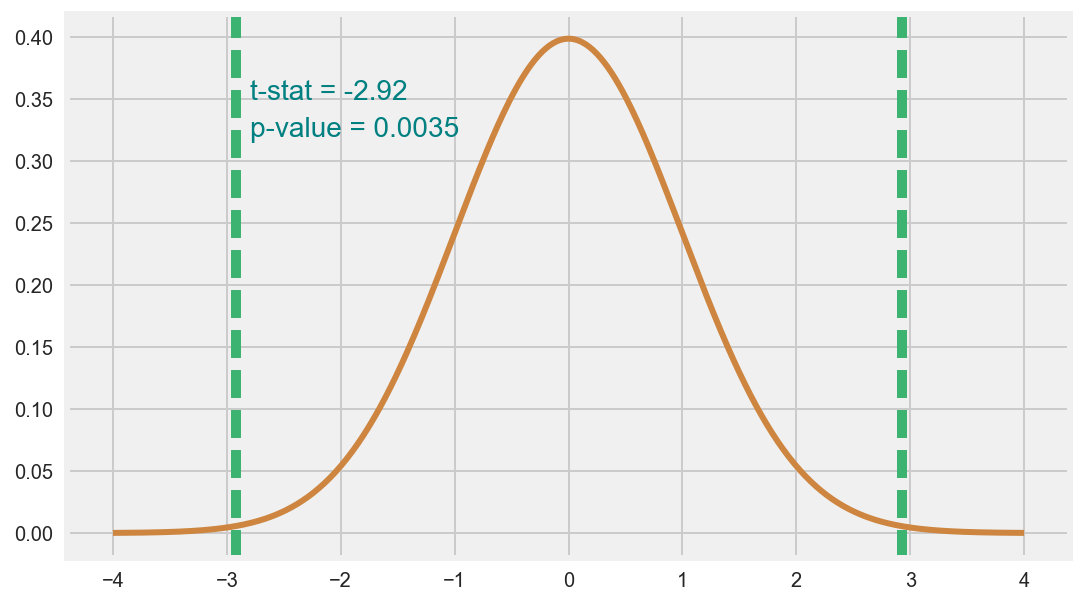

In [12]:
xpoints = np.linspace(-4, 4, 500)
ypoints = stats.t.pdf(xpoints, (559+788-2), 0, 1)       # 599 and 788 are the number of records, as shown above
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.plot(xpoints, ypoints, linewidth=3, color='peru')
ax.axvline(t_test[0], color='mediumseagreen', linestyle='--', lw=5)
ax.axvline(-t_test[0], color='mediumseagreen', linestyle='--', lw=5)
plt.title = 'Graph of t-statistic for Overall Fuel Economy'
ax.text(-2.8, 0.35, "t-stat = -2.92", color = 'teal', size = 14)
ax.text(-2.8, 0.32, "p-value = 0.0035", color = 'teal', size = 14)

#### <span style='color:midnightblue'> I'm going to conduct the same t-test on the difference in mean fuel economy with the Ray on and off, but this time for each individual driver. </span>

In [96]:
ttf_table = pd.DataFrame()
for i in summ_trip['driver_id'].unique():
    ttf_table.loc[i, 'Driver'] = i
    ttf_table.loc[i, 'Ray_on_trips'] = len(summ_trip[(summ_trip.ray_on == 1) & (summ_trip.driver_id == i)])
    ttf_table.loc[i, 'Ray_off_trips'] = len(summ_trip[(summ_trip.ray_on == 0) & (summ_trip.driver_id == i)])
    ttf_table.loc[i, 'Ray_on_time_avg'] = round((summ_trip[(summ_trip.ray_on == 1) & (summ_trip.driver_id == i)].
                                           trip_time.mean() / 60),2)
    ttf_table.loc[i, 'Ray_off_time_avg'] = round((summ_trip[(summ_trip.ray_on == 0) & (summ_trip.driver_id == i)].
                                           trip_time.mean() / 60),2)
    ttf_table.loc[i, 'Ray_on_fuel_econ'] = round((summ_trip[(summ_trip.ray_on == 1) & (summ_trip.driver_id == i)].
        fuel_used.sum() / summ_trip[(summ_trip.ray_on == 1) & (summ_trip.driver_id == i)].trip_dist.sum()) * 100 ,2)
    ttf_table.loc[i, 'Ray_off_fuel_econ'] = round((summ_trip[(summ_trip.ray_on == 0) & (summ_trip.driver_id == i)].
        fuel_used.sum() / summ_trip[(summ_trip.ray_on == 0) & (summ_trip.driver_id == i)].trip_dist.sum()) * 100 ,2)
    ray_on_samples = summ_trip[(summ_trip.ray_on == 1) & (summ_trip.driver_id == i)].fuel_econ
    ray_off_samples = summ_trip[(summ_trip.ray_on == 0) & (summ_trip.driver_id == i)].fuel_econ
    t_test = stats.ttest_ind(ray_on_samples, ray_off_samples)
    ttf_table.loc[i, 't-stat'] = round(t_test[0],3)
    ttf_table.loc[i, 'p-value'] = round(t_test[1],3)
    
ttf_table.reset_index(drop=True, inplace=True)

#### <span style='color:midnightblue'> The results are displayed below. </span>

In [97]:
def show_p_vals(val, max=0.05, color='lightgreen'):
    if val <= max:
        return 'background-color: %s' % color
    else:
        return ''

ttf_table.style.applymap(show_p_vals, subset=['p-value'])

#### <span style='color:midnightblue'> The results show that only three drivers have a difference in mean fuel economy with the Ray on and off at the 5% significance level, i.e. p = 0.05. There are far fewer trips for each individual driver than when considered together, which means that it is less likely that a significant difference will be indicated. </span>

#### <span style='color:midnightblue'> Despite these results, I'm not convinced of what it means. The test depends on the samples being a good representation of the populations from which they're drawn, and I'm not sure that's the case. I'll move on to some further analysis, after looking at the braking rate first. </span>

 ### <span style='color:royalblue'> Hard Braking </span>
 
 #### <span style='color:midnightblue'> I'll conduct the same t-tests for the hard / dangerous braking rate. </span>

In [13]:
brake_rate_mean_ray_on = (summ_trip[summ_trip.ray_on == 1].trip_brake.sum() / 
                         summ_trip[summ_trip.ray_on == 1].trip_dist.sum()) * 100
brake_rate_mean_ray_off = (summ_trip[summ_trip.ray_on == 0].trip_brake.sum() / 
                         summ_trip[summ_trip.ray_on == 0].trip_dist.sum()) * 100
brake_rate_trip_mean_ray_on = summ_trip[summ_trip.ray_on == 1].brake_rate.mean()
brake_rate_trip_mean_ray_off = summ_trip[summ_trip.ray_on == 0].brake_rate.mean()
print ('Overall brake rate mean with ray on = ', brake_rate_mean_ray_on, ' / 100km with ', 
       len(summ_trip[summ_trip.ray_on == 1].fuel_econ), 'samples.')
print ('Overall brake rate mean with ray off = ', brake_rate_mean_ray_off, ' / 100km with ', 
      len(summ_trip[summ_trip.ray_on == 0].fuel_econ), 'samples.')
print ('Trip brake rate mean with ray on = ', brake_rate_trip_mean_ray_on, ' / 100km')
print ('Trip brake rate mean with ray off = ', brake_rate_trip_mean_ray_off, '/ 100km')

t_test = stats.ttest_ind(summ_trip[summ_trip.ray_on == 1].brake_rate, 
                         summ_trip[summ_trip.ray_on == 0].brake_rate)

print (t_test)

Overall brake rate mean with ray on =  10.447126081775435  / 100km with  559 samples.
Overall brake rate mean with ray off =  14.904261273652656  / 100km with  788 samples.
Trip brake rate mean with ray on =  23.410299927229584  / 100km
Trip brake rate mean with ray off =  27.176434681617444 / 100km
Ttest_indResult(statistic=-0.94783430111302081, pvalue=0.34338407631209322)


#### <span style='color:midnightblue'> In this case, the p-value of 0.343 is indicating that there isn't a significant difference in hard braking when the Ray is off or on. </span>

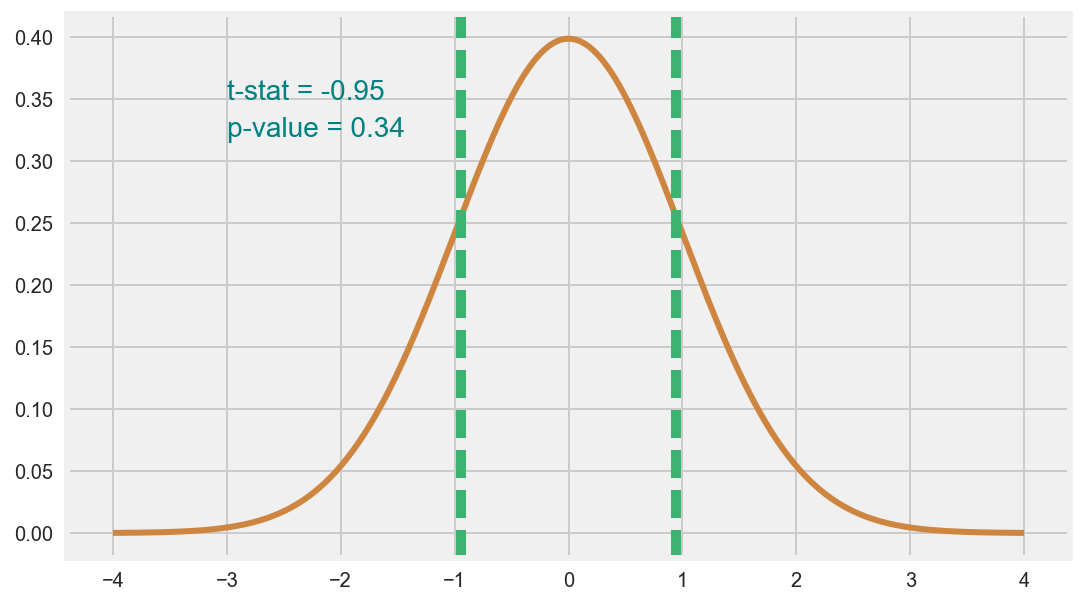

In [14]:
xpoints = np.linspace(-4, 4, 500)
ypoints = stats.t.pdf(xpoints, (559+788-2), 0, 1)
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.plot(xpoints, ypoints, linewidth=3, color='peru')
ax.axvline(t_test[0], color='mediumseagreen', linestyle='--', lw=5)
ax.axvline(-t_test[0], color='mediumseagreen', linestyle='--', lw=5)
plt.title = 'Graph of t-statistic for Dangerous Braking Rate'
ax.text(-3, 0.35, "t-stat = -0.95", color = 'teal', size = 14)
ax.text(-3, 0.32, "p-value = 0.34", color = 'teal', size = 14)

#### <span style='color:midnightblue'> Once more, I'll conduct the t-tests for the individual drivers. </span>

In [98]:
ttb_table = pd.DataFrame()
for i in summ_trip['driver_id'].unique():
    ttb_table.loc[i, 'Driver'] = i
    ttb_table.loc[i, 'Ray_on_trips'] = len(summ_trip[(summ_trip.ray_on == 1) & (summ_trip.driver_id == i)])
    ttb_table.loc[i, 'Ray_off_trips'] = len(summ_trip[(summ_trip.ray_on == 0) & (summ_trip.driver_id == i)])
    ttb_table.loc[i, 'Ray_on_brake_mean'] = round((summ_trip[(summ_trip.ray_on == 1) & (summ_trip.driver_id == i)].
        trip_brake.mean()),2)
    ttb_table.loc[i, 'Ray_off_brake_mean'] = round((summ_trip[(summ_trip.ray_on == 0) & (summ_trip.driver_id == i)].
        trip_brake.mean()),2)
    ttb_table.loc[i, 'Ray_on_brake_rate'] = round((summ_trip[(summ_trip.ray_on == 1) & (summ_trip.driver_id == i)].
        trip_brake.sum() / summ_trip[(summ_trip.ray_on == 1) & (summ_trip.driver_id == i)].trip_dist.sum()) * 100 ,2)
    ttb_table.loc[i, 'Ray_off_brake_rate'] = round((summ_trip[(summ_trip.ray_on == 0) & (summ_trip.driver_id == i)].
        trip_brake.sum() / summ_trip[(summ_trip.ray_on == 0) & (summ_trip.driver_id == i)].trip_dist.sum()) * 100 ,2)
    ray_on_samples = summ_trip[(summ_trip.ray_on == 1) & (summ_trip.driver_id == i)].brake_rate
    ray_off_samples = summ_trip[(summ_trip.ray_on == 0) & (summ_trip.driver_id == i)].brake_rate
    t_test = stats.ttest_ind(ray_on_samples, ray_off_samples)
    ttb_table.loc[i, 't-stat'] = round(t_test[0],3)
    ttb_table.loc[i, 'p-value'] = round(t_test[1],3)
    
ttb_table.reset_index(drop=True, inplace=True)

In [99]:
#from IPython.display import display, HTML

def show_p_vals(val, max=0.05, color='lightgreen'):
    if val <= max:
        return 'background-color: %s' % color
    else:
        return ''

ttb_table.style.applymap(show_p_vals, subset=['p-value'])

# display(HTML(ttb_table.to_html(index=False)))

#### <span style='color:midnightblue'> This is showing that there is a difference at the 5% significance level for two drivers. Driver 9 has far more dangerous braking events while the ray is on! However, there are only nine trips recorded, so I wouldn't be drawing any concrete conclusions. </span>

## <span style='color:royalblue'> <u> Modelling </u></span>

### <span style='color:royalblue'> k Nearest Neighbours - knn </span>

#### <span style='color:midnightblue'> Before I move on to further analysis, I'm going to sidetrack slightly. The only columns with missing data are the latitude and longitude (see below). I'm going to try to impute them, as I think that there may be a fair chance of success if a driver is taking the same route, e.g. to and from work. To begin with, I'll just look at driver 1. The method I'll use is k nearest neighbours, or knn. It uses the similarity to other points nearby to try to impute missing values. </span>

In [36]:
# df_one = pd.read_csv('../df_one.csv')

In [16]:
drive.isnull().sum()

speed                     0
rpm                       0
distance                  0
liter                     0
xaxisacceleration         0
yaxisacceleration         0
zaxisgyroscope            0
longitude            311733
latitude             311733
timestamp_utc             0
trip_index                0
tripid                    0
ray_connected             0
driver_id                 0
date_time                 0
delta_time                0
calc_dist                 0
dtype: int64

#### <span style='color:midnightblue'> I'll create a new DataFrame with data just for driver 1. The 'date_time' field will be converted from string to datetime, then set as the index. This will allow plotting by date.  </span>

In [39]:
df_one = drive[drive.driver_id == '1'].copy(deep=True)

In [29]:
drive.columns

Index(['speed', 'rpm', 'distance', 'liter', 'xaxisacceleration',
       'yaxisacceleration', 'zaxisgyroscope', 'longitude', 'latitude',
       'timestamp_utc', 'trip_index', 'tripid', 'ray_connected', 'driver_id',
       'date_time', 'delta_time', 'calc_dist'],
      dtype='object')

In [40]:
for i in range(len(df_one)):
    df_one.loc[i, 'date_time'] = pd.to_datetime(df_one.loc[i, 'date_time']).to_pydatetime()  # Convert to datetime

In [41]:
df_one_trip = df_one.copy(deep=True)
df_one_trip.set_index('date_time', inplace=True)     # Setting the index to date_time to allow plotting against date

#### <span style='color:midnightblue'> I'll plot driver 1's trips below. </span>

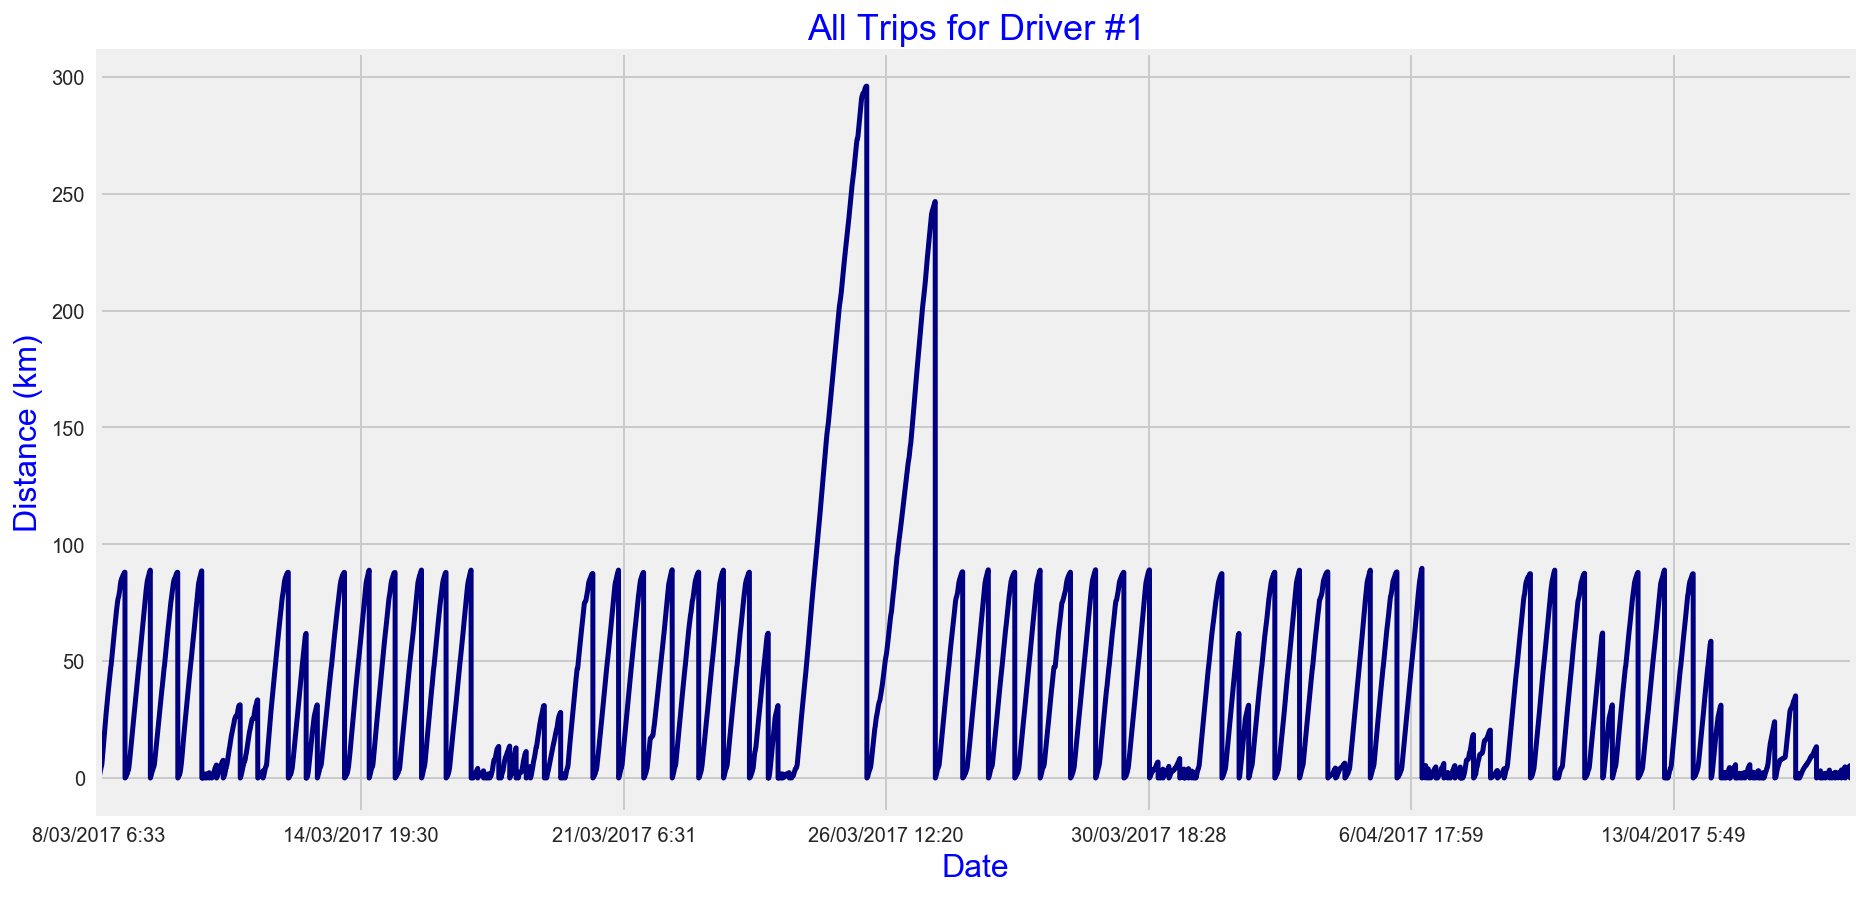

In [22]:
ax = df_one_trip.calc_dist.plot(lw=2.5, figsize=(14,7), colormap='jet', title = 'Driver 1')
ax.set_xlabel('Date', size = 16, color='blue')
ax.set_ylabel('Distance (km)', size = 16, color='blue')
ax.set_title('All Trips for Driver #1', size = 18, color='blue')

#### <span style='color:midnightblue'> There is a fairly consistent pattern from Monday to Thursday, I'm guessing that this driver works four days a week! Note that this is a plot of distance travelled. Each trip starts from zero, so each peak, up and down, is one trip. </span>

In [19]:
df_one_miss = df_one.loc[df_one.latitude.isnull(), :]   # All the lines missing latitude and longitude
df_one_good = df_one.loc[~df_one.latitude.isnull(), :]  # All the lines with latitude and longitude
df_one_good.reset_index(inplace = True)
df_one_miss.reset_index(inplace = True)

#### <span style='color:midnightblue'> I'm going to plot a map to see where the driver has been, using the latitude and longitude values that are there. This isn't strictly necessary, but it looks good! Plus, I'll use it later to see how sucessful the imputation has been. </span>

In [21]:
import folium

In [56]:
locations = []
for i in range(len(df_one_good)-1):
    a = ()
    b = ()
    c = []
    a = (df_one_good.loc[i, 'latitude'], df_one_good.loc[i, 'longitude'])
    b = (df_one_good.loc[i+1, 'latitude'], df_one_good.loc[i+1, 'longitude'])
    c.append(a)
    c.append(b)
    locations.append(c)

m = folium.Map(location = [51.8, -1.9], zoom_start=8.6)
m.add_child(folium.PolyLine(locations=locations, color='midnightblue',
                    weight=5, opacity=0.5))

m.save('../images/driver_one_map.html')

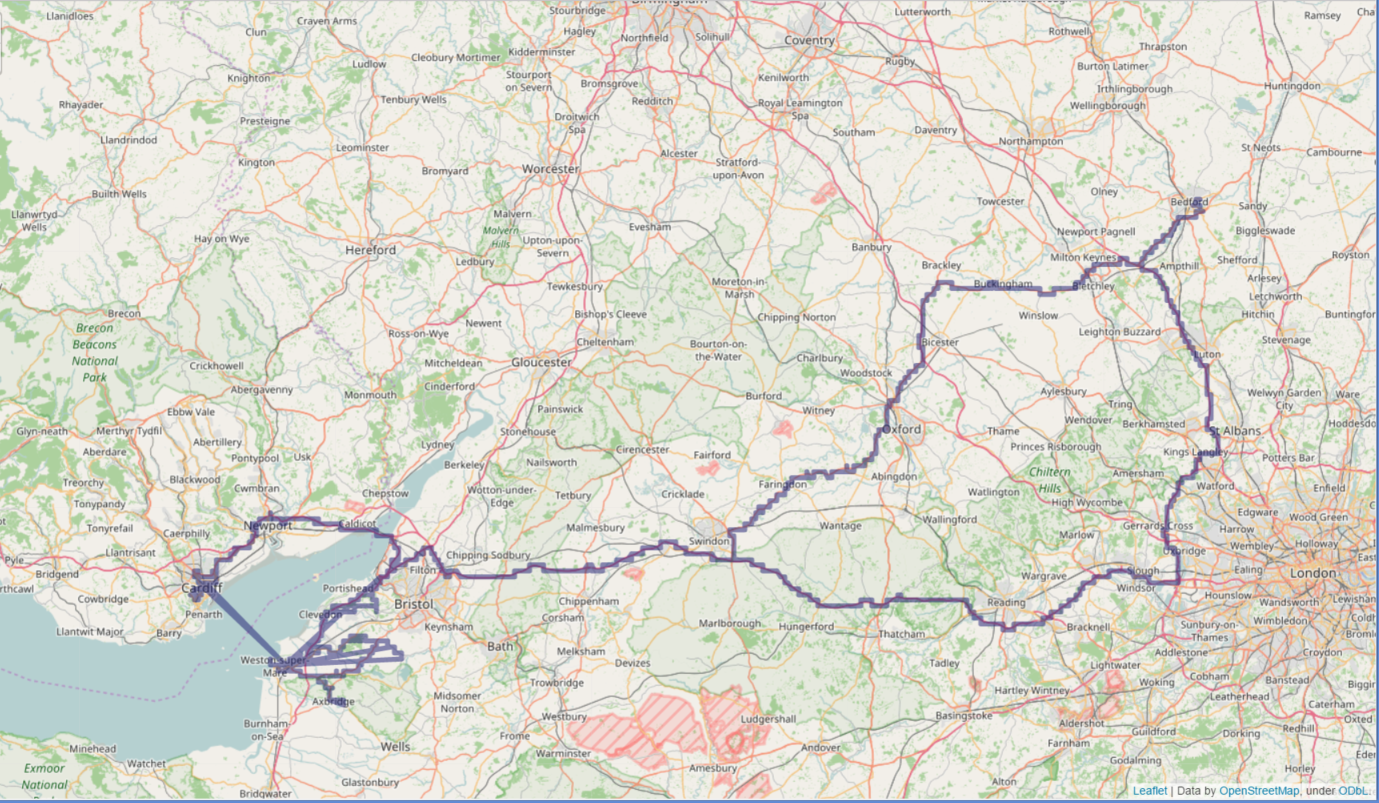

In [104]:
from IPython.display import Image
fig = Image(filename=('../images/driver_one_map.png'))
fig

# Note that you can display the html files with the code below, but I was finding that they made the notebook  
# unstable, so I created .png files instead. 

#%%HTML
#<iframe width="125%" height ="650" src='../driver_one_map.html'></iframe>

#### <span style='color:midnightblue'> To get an idea of what's missing, I'll split the records into those with latitude and longitude and those where they're missing, then plot the distance against the date again.

In [35]:
df_one_trip.index

Index(['2017-03-08 06:33:31', '2017-03-08 06:33:33', '2017-03-08 06:33:35',
       '2017-03-08 06:33:37', '2017-03-08 06:33:40', '2017-03-08 06:33:42',
       '2017-03-08 06:33:45', '2017-03-08 06:33:47', '2017-03-08 06:33:49',
       '2017-03-08 06:33:51',
       ...
       '2017-04-22 11:34:49', '2017-04-22 11:34:51', '2017-04-22 11:34:53',
       '2017-04-22 11:34:55', '2017-04-22 11:34:58', '2017-04-22 11:35:00',
       '2017-04-22 11:35:02', '2017-04-22 11:35:04', '2017-04-22 11:35:06',
       '2017-04-22 11:35:08'],
      dtype='object', name='date_time', length=133647)

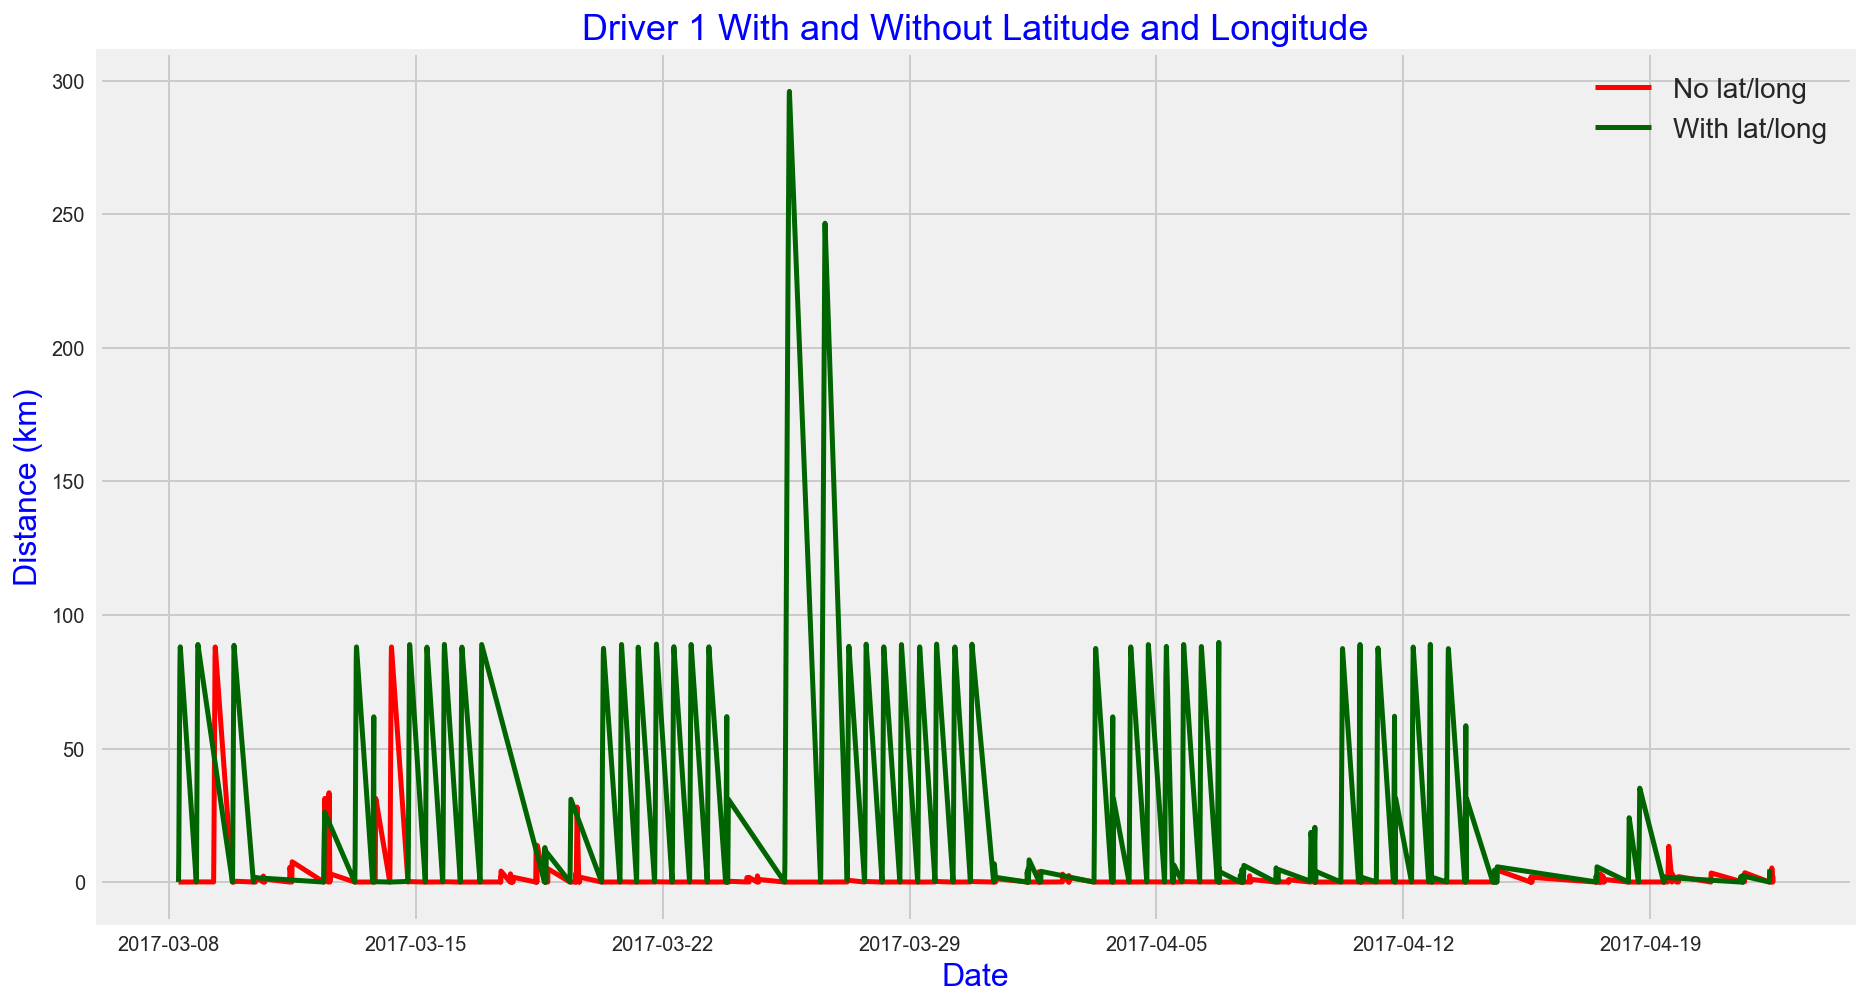

In [42]:
fig = plt.figure(figsize=(14,8))
ax  = fig.gca()
ax.plot(df_one_trip[df_one_trip['latitude'].isnull()].calc_dist, lw=2.5, color='red', label='No lat/long')
ax.plot(df_one_trip[~df_one_trip['latitude'].isnull()].calc_dist, lw=2.5, color='darkgreen', label='With lat/long')
ax.set_title('Driver 1 With and Without Latitude and Longitude', size=18, color='blue')
ax.set_xlabel('Date', size = 16, color='blue')
ax.set_ylabel('Distance (km)', size = 16, color='blue')
plt.legend(loc='upper right', fontsize=14)
plt.show()

#### <span style='color:midnightblue'> I think that, realistically, there is only a chance of imputing the records from Monday to Thursday, which show a regular pattern. To help with the imputation, I'll create some more fields for the day of the week, month, day, hour and minute. </span>

In [ ]:
for i in df_one_trip.index:
    df_one_trip.loc[i, 'day_of_week'] = i.weekday()
df_one_trip['day_of_week'].value_counts()

In [114]:
for i in df_one_trip.index:
    df_one_trip.loc[i, 'trip_month'] = i.month
    df_one_trip.loc[i, 'trip_day'] = i.day
    df_one_trip.loc[i, 'trip_hour'] = i.hour
    df_one_trip.loc[i, 'trip_minute'] = i.minute

In [23]:
df_one_trip.columns

Index(['speed', 'rpm', 'distance', 'liter', 'xaxisacceleration',
       'yaxisacceleration', 'zaxisgyroscope', 'longitude', 'latitude',
       'timestamp_utc', 'trip_index', 'tripid', 'ray_connected', 'driver_id',
       'delta_time', 'calc_dist'],
      dtype='object')

In [129]:
df_one_trip = pd.DataFrame(df_one_trip.to_records())

In [9]:
# df_one_trip.to_csv('../df_one_trip.csv')
# time_df.to_csv('../time_df.csv')
# time_df = pd.read_csv('../time_df.csv')
# df_one_trip = pd.read_csv('../df_one_trip.csv')

#### <span style='color:midnightblue'> I'll retrieve just the Monday to Thursday records. </span>

In [223]:
df_one_trip_mt = df_one_trip[df_one_trip.day_of_week < 4.0]

#### <span style='color:midnightblue'> The information that I think is most relevant in matching a missing trip to others is the day of the week, hour and distance. The trip index will also help with this. </span>

In [229]:
imp_cols = ['trip_index', 'calc_dist', 'trip_hour', 'day_of_week']

y = df_one_trip_mt.latitude[~df_one_trip_mt.latitude.isnull()].values
X = df_one_trip_mt[~df_one_trip_mt.latitude.isnull()][imp_cols]

#### <span style='color:midnightblue'> The data needs to be scaled as the algorithm uses distance, so is sensitive to one variable being on a much larger scale than another. </span>

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

ss = StandardScaler()
Xs = ss.fit_transform(X)

#### <span style='color:midnightblue'> I'll use a function to find the k and cross-validated parameters that give the best score. A range of 1-8 will be tested for k, and 2-6 for the number of folds.

In [231]:
from sklearn.neighbors import KNeighborsRegressor

def find_k_cv(X, y, k_min=1, k_max=8, step=1, cv_min=2, cv_max=6):
    k_range = range(k_min, k_max+1, step)
    cv_range = range(cv_min, cv_max+1, step)
    result = []
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        for cv in cv_range:
            scores = cross_val_score(knn, X, y, cv=cv)
            result.append(np.mean(scores))
    print (np.max(result), np.argmax(k_range), np.argmax(cv_range))
    return np.argmax(k_range)
    return np.argmax(cv_range)

In [47]:
k_cv = find_k_cv(Xs, y)

0.625253208046 7 4


#### <span style='color:midnightblue'> A k of 7 returns the best score, using four folds. It will be used in the model. The latitude and longitude will be imputed separately. </span>

In [232]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(Xs, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')

In [233]:
X_miss = df_one_trip_mt[df_one_trip_mt.latitude.isnull()][imp_cols]   # These are the records missing latitude and
X_miss_s = ss.transform(X_miss)                                       # longitude for Monday - Thursday

In [234]:
lat_impute = knn.predict(X_miss_s)      # This imputes the latitude

#### <span style='color:midnightblue'> I'll take a copy of the dataframe and add the imputed latitudes

In [235]:
df_one_imp_mt = df_one_trip_mt.copy()
df_one_imp_mt.loc[df_one_trip_mt.latitude.isnull(), 'latitude'] = lat_impute

#### <span style='color:midnightblue'> Now to calculate and add the longitudes to the dataframe. </span>

In [236]:
y = df_one_trip_mt.longitude[~df_one_trip_mt.longitude.isnull()].values
knn.fit(Xs, y)
long_impute = knn.predict(X_miss_s)
df_one_imp_mt.loc[df_one_trip_mt.longitude.isnull(), 'longitude'] = long_impute

In [237]:
df_one_imp_mt.reset_index(drop=True, inplace=True)

In [238]:
# This is to separate the Monday - Thursday records with and without latitude and longitude
df_one_miss_mt = df_one_trip_mt.loc[df_one.latitude.isnull(), :]
df_one_good_mt = df_one_trip_mt.loc[~df_one.latitude.isnull(), :]

In [239]:
df_one_miss_mt.reset_index(drop=True, inplace=True)
df_one_good_mt.reset_index(drop=True, inplace=True)

#### <span style='color:midnightblue'> Now that I've imputed the missing latitudes and longitudes for Monday to Thursday, I'll show them on the map in blue, with the actual records in green.

In [196]:
locations = []
for i in range(len(df_one_good_mt)-1):
    a = ()
    b = ()
    c = []
    a = (df_one_good_mt.loc[i, 'latitude'], df_one_good_mt.loc[i, 'longitude'])
    b = (df_one_good_mt.loc[i+1, 'latitude'], df_one_good_mt.loc[i+1, 'longitude'])
    c.append(a)
    c.append(b)
    locations.append(c)
    
locations_imp = []
for i in range(len(lat_impute)-1):
    a = ()
    b = ()
    c = []
    a = (lat_impute[i], long_impute[i])
    b = (lat_impute[i+1], long_impute[i+1])
    c.append(a)
    c.append(b)
    locations_imp.append(c)

m = folium.Map(location = [51.5, -2.8], zoom_start=10.5)
m.add_child(folium.PolyLine(locations=locations_imp, color='midnightblue', weight=3, opacity=1.0))
m.add_child(folium.PolyLine(locations=locations, color='darkgreen', weight=8, opacity=0.5))

m.save('../driver_one_map_mt_imp.html')

In [225]:
# df_one_trip = pd.read_csv('../df_one_trip.csv')
# df_one_imp_mt = pd.read_csv('../df_one_imp_mt.csv')

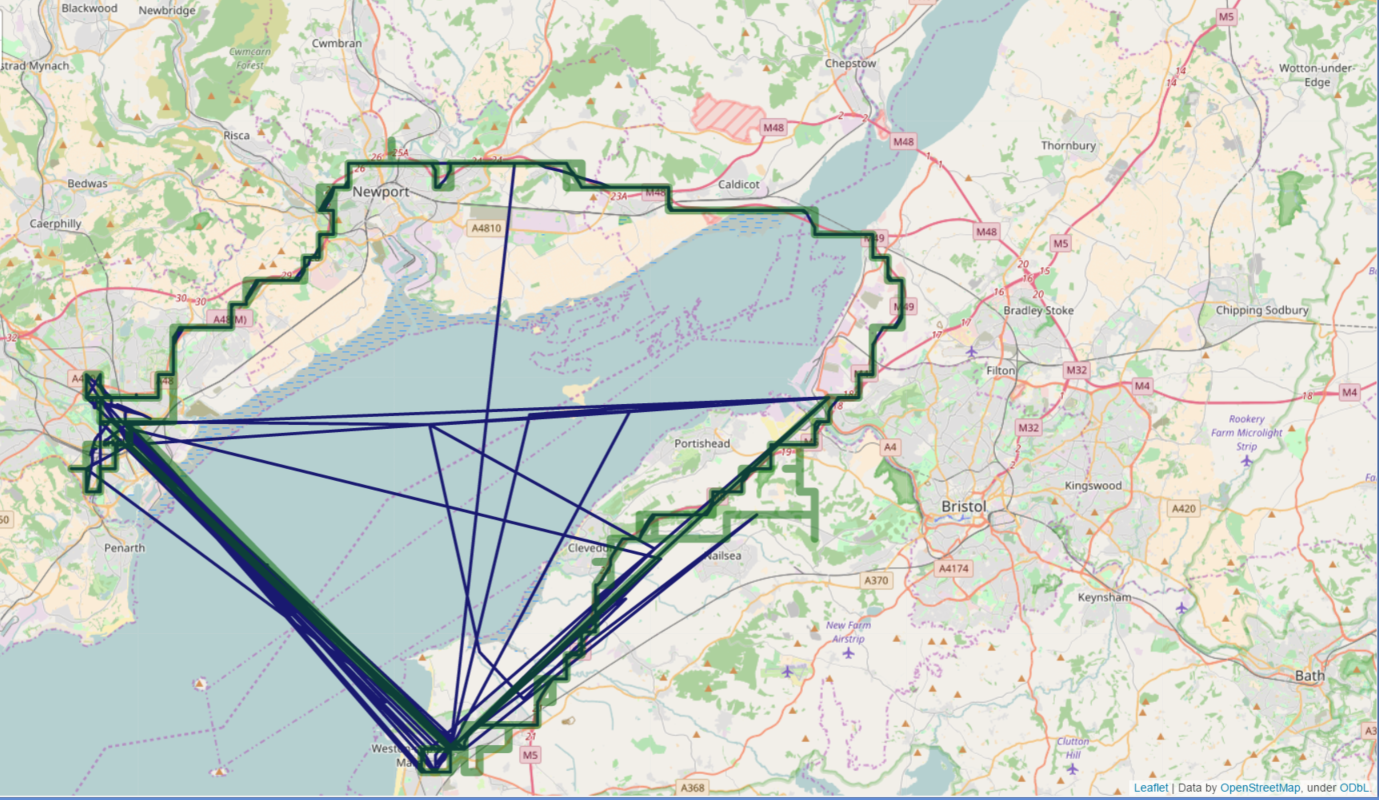

In [144]:
from IPython.display import Image
fig = Image(filename=('../driver_one_map_mt_imp.png'))
fig

# %%HTML
# <iframe width="120%" height ="700" src='../driver_one_map_mt_imp.html'></iframe>

#### <span style='color:midnightblue'> Although the lines back and forth across the water make it look as though the result hasn't been very good, these are caused by a few missing records within the trips that mostly have data. Because I've plotted the imputed data separately, points from different trips are next to each other in the list and are being joined together. However, this map does show that the blue line follows the green line closely in the rough circle the driver makes around the harbour, so it has imputed at least one of the missing trips quite well. I'll put all the records together on a map below, which will give a better idea of the result. </span>

In [58]:
import folium

locations = []
for i in range(len(df_one_imp_mt)-1):
    a = ()
    b = ()
    c = []
    a = (df_one_imp_mt.loc[i, 'latitude'], df_one_imp_mt.loc[i, 'longitude'])
    b = (df_one_imp_mt.loc[i+1, 'latitude'], df_one_imp_mt.loc[i+1, 'longitude'])
    c.append(a)
    c.append(b)
    locations.append(c)

m = folium.Map(location = [51.5, -2.8], zoom_start=10.5)
m.add_child(folium.PolyLine(locations=locations, color='midnightblue', weight=5, opacity=0.5))

m.save('../driver_one_imp_final.html')

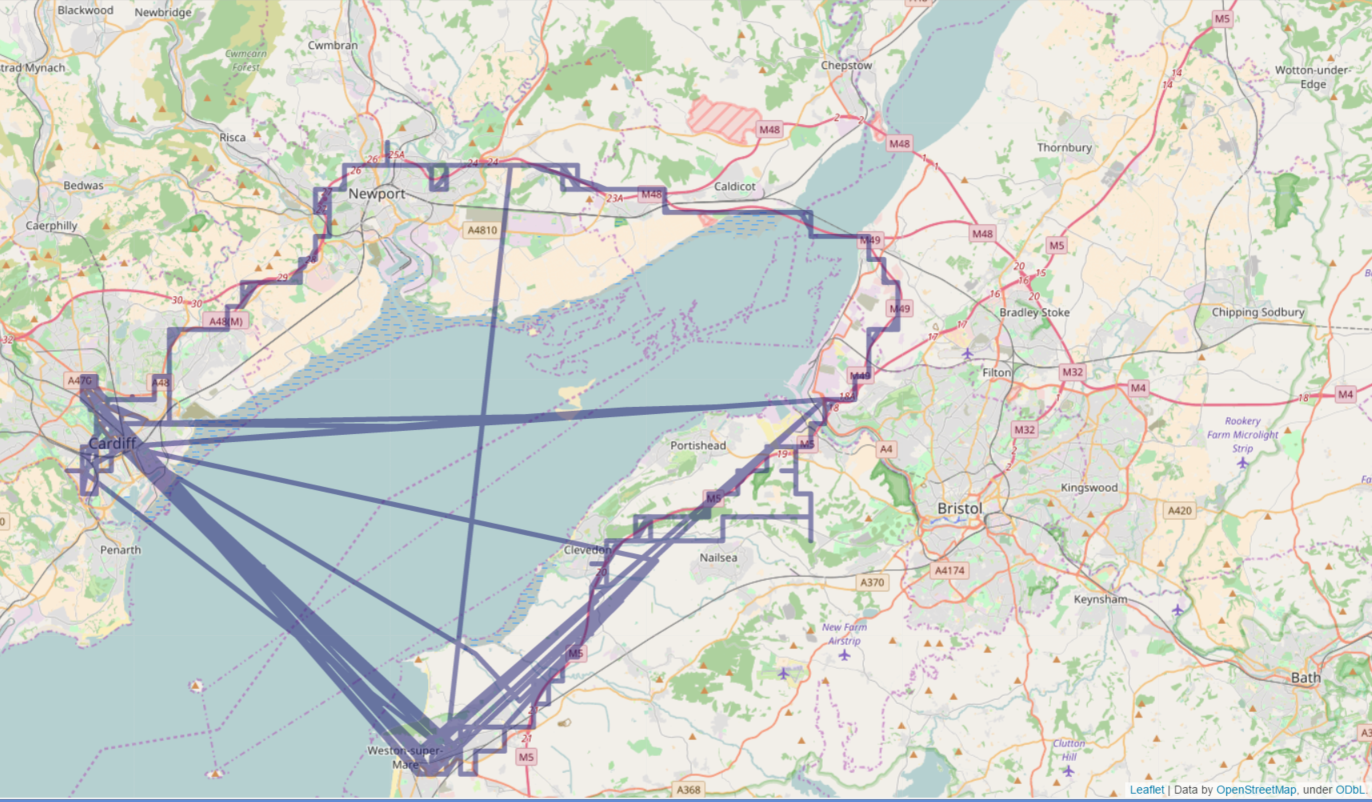

In [62]:
from IPython.display import Image
fig = Image(filename=('../driver_one_imp_final.png'))
fig

In [59]:
# df_one_imp_mt.to_csv('../df_one_imp_mt.csv')

#### <span style='color:midnightblue'> Not perfect, but a better result when all the data is displayed together. </span>

#### <span style='color:midnightblue'> Although I think that a lot of the imputed calculations are good, the latitudes and longitudes are only given to two decimal places, which corresponds to a distance of approximately 1.1 km between points (a good thing, considering privacy concerns). This isn't going to be accurate enough to help with any calculations, so I'm not going to try to improve the results, or tidy up the map above by plotting just the points without lines, for example. I'll move on to other analysis. </span>


### <span style='color:royalblue'> Linear Regression </span>

#### <span style='color:midnightblue'> Instead, I'm going to set up a new dataframe for a linear regression. I will attempt to build a model to show whether the Ray is affecting the fuel economy. </span>

In [65]:
time_df = pd.DataFrame()

time_df['driver_id'] = summ_trip['driver_id']
time_df['trip_dist'] = summ_trip['trip_dist']
time_df['fuel_econ'] = summ_trip['fuel_econ']
time_df['trip_time'] = summ_trip['trip_time']
time_df['trip_ave_speed'] = summ_trip['trip_ave_speed']
time_df['ray_on'] = summ_trip['ray_on']
time_df['brake_rate'] = summ_trip['brake_rate']
time_df['trip_rpm'] = summ_trip['trip_rpm']
time_df['trip_start'] = summ_trip['trip_start']

for i in range(len(time_df)):
    time_df.loc[i, 'trip_start'] = pd.to_datetime(time_df.loc[i, 'trip_start']).to_pydatetime()
time_df.ray_on = time_df.ray_on.astype(str)
time_df.set_index('trip_start', inplace=True)     # This is to make it easier to create new variables based on date

#### <span style='color:midnightblue'> I'll create some new columns to show the day of the week. These are categorical data, so will need to be turned into dummy variables. </span>

In [66]:
days_of_week = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'friday', 
                5: 'saturday', 6: 'sunday'}

for i in time_df.index:
    time_df.loc[i, 'day_of_week'] = days_of_week[i.weekday()]
time_df['day_of_week'].value_counts()

friday       226
thursday     208
saturday     203
wednesday    197
tuesday      190
monday       168
sunday       155
Name: day_of_week, dtype: int64

In [67]:
dummy = pd.get_dummies(time_df['day_of_week'])
time_df = pd.concat([time_df, dummy], axis=1)

#### <span style='color:midnightblue'> I'll also create some variables for the time of day, broken into four periods: </span>
<span style='color:midnightblue'> 1. Morning peak: 6 - 10 a.m. </span>

<span style='color:midnightblue'> 2. Between peaks: 10 a.m. - 3 p.m. </span>

<span style='color:midnightblue'> 3. Afternoon peak: 3 - 7 p.m. </span>

<span style='color:midnightblue'> 4. Off peak: 7 p.m. - 6 a.m.</span>

In [71]:
for i in time_df.index:
    if (i.hour) < 6:
        time_df.loc[i, 'time_of_day'] = 'off_peak'
    elif (i.hour) < 10:
        time_df.loc[i, 'time_of_day'] = 'morning_peak'
    elif (i.hour) < 15:
        time_df.loc[i, 'time_of_day'] = 'between_peak'
    elif (i.hour) < 19:
        time_df.loc[i, 'time_of_day'] = 'afternoon_peak'
    else:
        time_df.loc[i, 'time_of_day'] = 'off_peak'

In [73]:
dummy = pd.get_dummies(time_df['time_of_day'])
time_df = pd.concat([time_df, dummy], axis=1)

In [75]:
dummy = pd.get_dummies(time_df['driver_id'])
time_df = pd.concat([time_df, dummy], axis=1)

In [76]:
time_df.columns

Index(['driver_id', 'trip_dist', 'fuel_econ', 'trip_time', 'trip_ave_speed',
       'ray_on', 'brake_rate', 'trip_rpm', 'day_of_week', 'friday', 'monday',
       'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday', 'time_of_day',
       'afternoon_peak', 'between_peak', 'morning_peak', 'off_peak', '1', '10',
       '11', '12', '13', '14', '15', '16', '18', '19', '21', '22', '23', '3',
       '5', '6', '7', '8', '9'],
      dtype='object')

In [78]:
time_df = pd.DataFrame(time_df.to_records())     # I no longer need the date_time as index

In [90]:
time_df.ray_on = time_df.ray_on.astype('int')

#### <span style='color:midnightblue'> Now to set up the values for a regression. Trip start has been replaced by the time of day variables. Trip time is used to calculate average speed from the distance, so will be excluded.  </span>

In [52]:
tdf_cols = list(time_df.columns)
tdf_cols.remove('fuel_econ') 
tdf_cols.remove('trip_start')
tdf_cols.remove('trip_time')
tdf_cols.remove('day_of_week')
tdf_cols.remove('time_of_day')
tdf_cols.remove('driver_id')
tdf_cols.remove('sunday')              # I'll use Sunday as the reference for day of the week
tdf_cols.remove('off_peak')            # Off peak will be the time of day reference
tdf_cols.remove('8')                   # Driver 8 is the driver reference

X_fe = time_df[tdf_cols]
y_fe = time_df.fuel_econ.values
X_fe.columns

Index(['trip_dist', 'trip_ave_speed', 'ray_on', 'brake_rate', 'trip_rpm',
       'friday', 'monday', 'saturday', 'thursday', 'tuesday', 'wednesday',
       'afternoon_peak', 'between_peak', 'morning_peak', '1', '10', '11', '12',
       '13', '14', '15', '16', '18', '19', '21', '22', '23', '3', '5', '6',
       '7', '9'],
      dtype='object')

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [53]:
X_fec = sm.add_constant(X_fe)       # statsmodel doesn't fit the intercept by default, so a constant needs 
model = sm.OLS(y_fe, X_fec)         # to be added to force it to.
model = model.fit()
predictions = model.predict()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     89.87
Date:                Tue, 06 Jun 2017   Prob (F-statistic):          8.25e-304
Time:                        00:54:04   Log-Likelihood:                -3168.6
No. Observations:                1347   AIC:                             6403.
Df Residuals:                    1314   BIC:                             6575.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              7.7486      0.722     10.735      0.000         6.332     9.165
trip_dist          0.0195      0.004      5.053      0.000         0.012     0.027
trip_ave_speed    -0.2353      0.008    -27.683      0.000        -0.252    -0.219
ray_on            -0.3934      0.150     -2.615      0.009        -0.688    -0.098
brake_rate         0.0045      0.001      4.113      0.000         0.002     0.007
trip_rpm           0.0080      0.000     20.706      0.000         0.007     0.009
friday            -0.4402      0.279     -1.578      0.115        -0.988     0.107
monday            -0.6099      0.297     -2.053      0.040        -1.193    -0.027
saturday          -0.4074      0.279     -1.461      0.144        -0.954     0.140
thursday          -0.1949      0.289     -0.675      0.500        -0.761     0.372
tuesday           -0.5842      0.295     -1.983      0.048        -1.162    -0.006
wednesday         -0.5352      0.296     -1.806      0.071        -1.116     0.046
afternoon_peak    -0.3802      0.231     -1.643      0.101        -0.834     0.074
between_peak      -0.3940      0.262     -1.504      0.133        -0.908     0.120
morning_peak      -0.9122      0.249     -3.670      0.000        -1.400    -0.425
1                 -1.0970      0.647     -1.696      0.090        -2.366     0.172
10                -7.7791      0.732    -10.627      0.000        -9.215    -6.343
11                -1.2145      0.715     -1.698      0.090        -2.618     0.189
12                -4.4279      0.670     -6.607      0.000        -5.743    -3.113
13                -3.4152      0.754     -4.531      0.000        -4.894    -1.937
14                -3.3572      0.684     -4.908      0.000        -4.699    -2.015
15                -0.4325      0.667     -0.649      0.517        -1.740     0.875
16                -3.3638      0.932     -3.611      0.000        -5.191    -1.536
18                -0.5048      0.675     -0.748      0.455        -1.829     0.820
19                -5.4873      0.699     -7.852      0.000        -6.858    -4.116
21                 7.5755      0.699     10.837      0.000         6.204     8.947
22                -6.0758      0.749     -8.110      0.000        -7.545    -4.606
23                -4.1866      0.814     -5.141      0.000        -5.784    -2.589
3                 -3.3893      0.708     -4.790      0.000        -4.778    -2.001
5                  1.5448      0.733      2.108      0.035         0.107     2.982
6                 -5.8029      0.748     -7.759      0.000        -7.270    -4.336
7                 -2.7499      0.679     -4.048      0.000        -4.083    -1.417
9                 -2.2340      0.718     -3.111      0.002        -3.643    -0.825
==============================================================================
Omnibus:        

In [54]:
print ("MSE:", mean_squared_error(y_fe, predictions))
print ("RMSE:", np.sqrt(mean_squared_error(y_fe, predictions)))

MSE: 6.46795322327
RMSE: 2.54321710109


#### <span style='color:midnightblue'> The results indicate that the Ray being on is significant in this model, with a p-value of 0.009. Interestingly, the brake rate is also significant. I'll examine the results a bit further. </span>

In [55]:
time_df['predictions'] = predictions
time_df['residuals'] = time_df['fuel_econ'] - time_df['predictions']

#### <span style='color:midnightblue'> Below is a scatter plot of the actual fuel economy against that predicted by the model. Separate regression lines for when the ray is on and off have been added. It shows that the linear regression model includes an effect for the ray being on. It is slightly less, meaning that less fuel is being used. Underneath that is a plot of all the data with the regression line. </span>

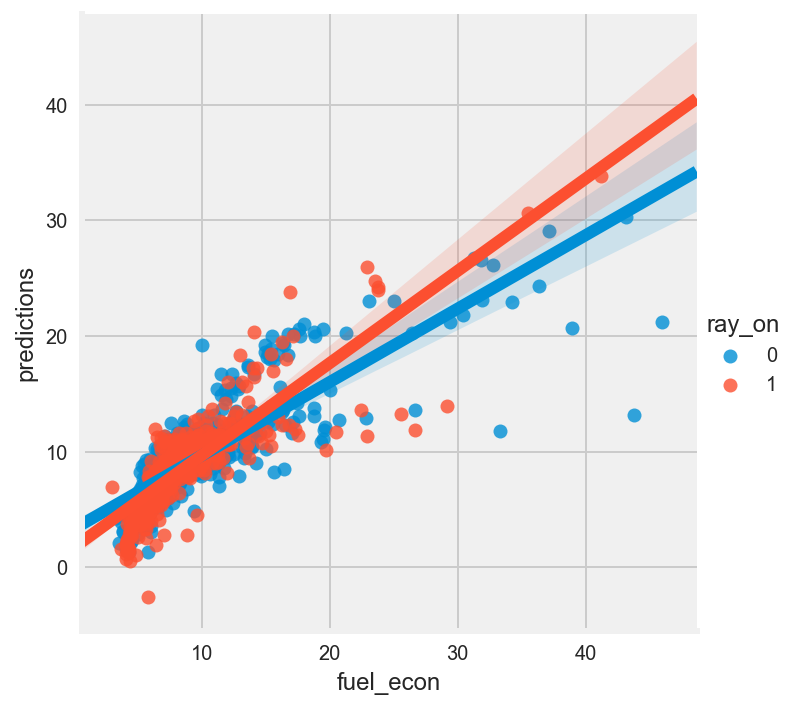

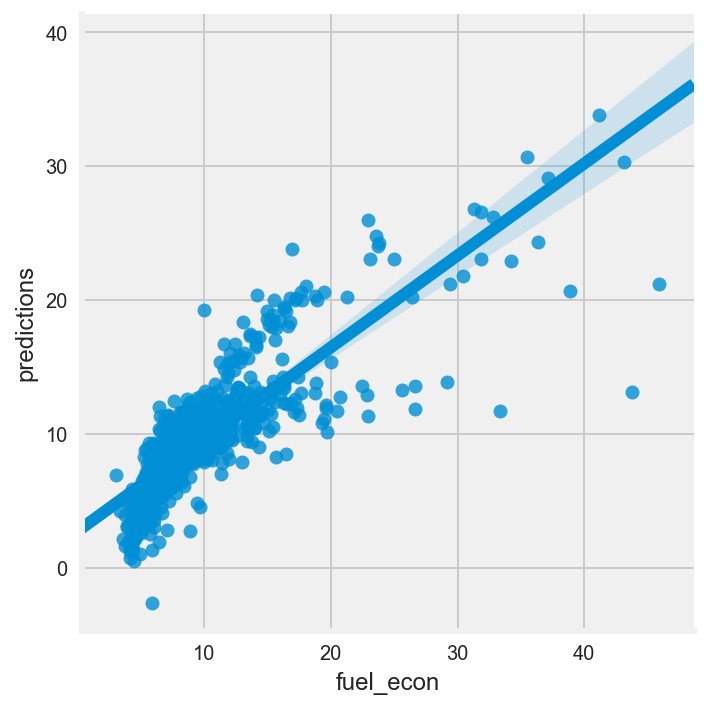

In [56]:
sns.lmplot(x='fuel_econ', y='predictions', data=time_df, hue='ray_on')
sns.lmplot(x='fuel_econ', y='predictions', data=time_df)

#### <span style='color:midnightblue'> This is another plot of the predicted versus actual values, with the line y=x to allow the accuracy to be more easily judged. </span>

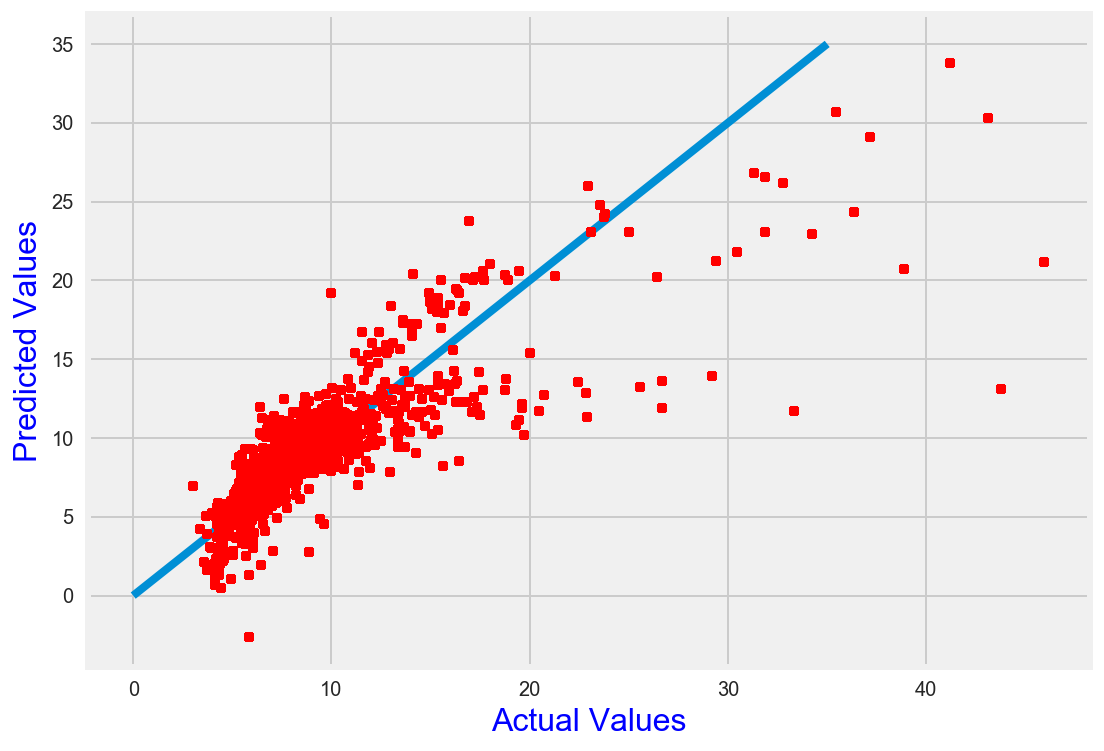

MSE: 6.46795322327
RMSE: 2.54321710109


In [63]:
plt.figure(figsize=(8,6))
plt.scatter(y_fe, predictions, s=30, c='r', marker='+', zorder=10)
plt.ylabel("Predicted Values", size=16, color='blue')
plt.xlabel("Actual Values", size=16, color='blue')
p1, p2 = [0,35], [0,35]
plt.plot(p1,p2)
plt.show()
print ("MSE:", mean_squared_error(y_fe, predictions))
print ("RMSE:", np.sqrt(mean_squared_error(y_fe, predictions)))

#### <span style='color:midnightblue'> One of the requirements for linear regression to be accurate is that the residuals be normally distributed. The plot below shows that they are close, although skewed to the left. The second graph is a plot of the residuals against the trip distance. The residuals should also be evenly spread when plotted against each variable. </span>

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


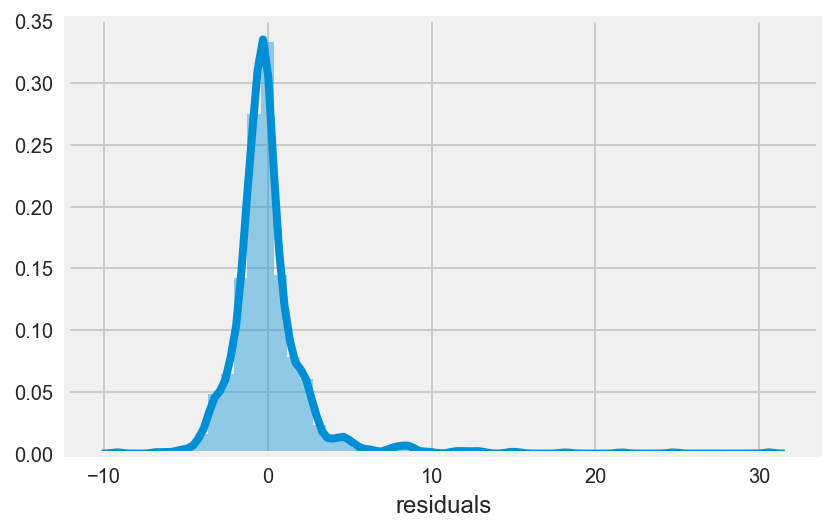

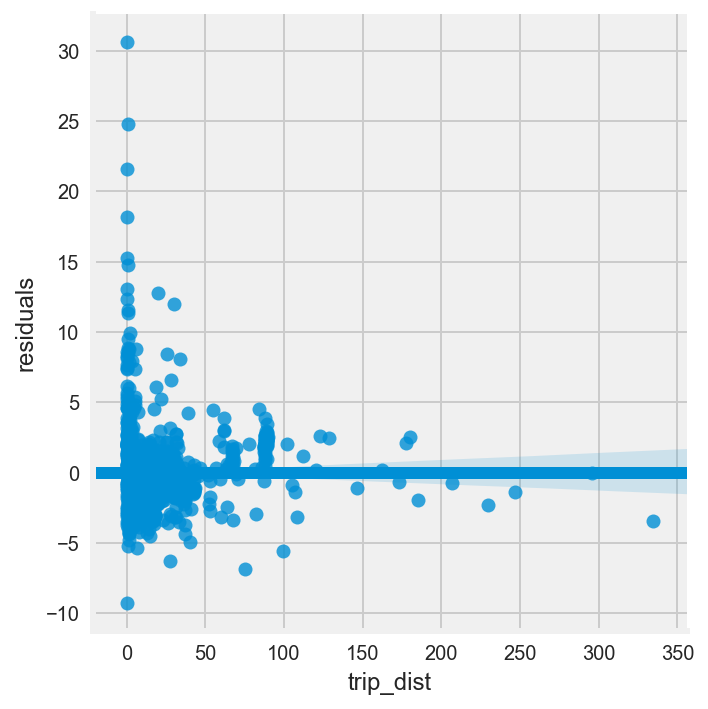

In [58]:
sns.distplot(time_df['residuals'])
sns.lmplot(x='trip_dist', y='residuals', data=time_df)

#### <span style='color:midnightblue'> I know that with only 19 drivers, this sample is not going to be representative of the whole population. Still, I'd like to see what the result would be if I removed the drivers from the model. I'm going to do two more regression tests without them. One will include the ray_is_on variable, and the other won't. I'll compare the RMSE (residual mean squared error) of each model to get an  idea of which is better. </span>

In [60]:
tdf_cols = ['trip_dist', 'trip_ave_speed', 'trip_rpm', 'brake_rate', 'friday', 'monday', 'saturday', 'thursday', 
            'tuesday', 'wednesday', 'ray_on', 'afternoon_peak', 'between_peak', 'morning_peak']

X_fe2 = time_df[tdf_cols]
y_fe2 = time_df.fuel_econ.values

In [61]:
X_fe2 = sm.add_constant(X_fe2)       # statsmodel doesn't fit the intercept by default, so a constant needs to be added
model_2 = sm.OLS(y_fe2, X_fe2)
model_2 = model_2.fit()
predictions_2 = model_2.predict()

time_df['predictions_2'] = predictions_2
time_df['residuals_2'] = time_df['fuel_econ'] - time_df['predictions_2']

print ("MSE:", mean_squared_error(y_fe2, predictions_2))
print ("RMSE:", np.sqrt(mean_squared_error(y_fe2, predictions_2)))

model_2.summary()

MSE: 15.1278953448
RMSE: 3.88945951834


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     34.56
Date:                Tue, 06 Jun 2017   Prob (F-statistic):           1.07e-79
Time:                        01:14:23   Log-Likelihood:                -3740.9
No. Observations:                1347   AIC:                             7512.
Df Residuals:                    1332   BIC:                             7590.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              9.5112      0.685     13.877      0.000         8.167    10.856
trip_dist          0.0129      0.006      2.261      0.024         0.002     0.024
trip_ave_speed    -0.1389      0.011    -12.320      0.000        -0.161    -0.117
trip_rpm           0.0033      0.000      7.717      0.000         0.002     0.004
brake_rate         0.0144      0.002      9.340      0.000         0.011     0.017
friday            -1.6884      0.414     -4.074      0.000        -2.501    -0.875
monday            -2.0271      0.442     -4.586      0.000        -2.894    -1.160
saturday          -1.3400      0.420     -3.190      0.001        -2.164    -0.516
thursday          -1.7623      0.428     -4.118      0.000        -2.602    -0.923
tuesday           -2.3204      0.437     -5.312      0.000        -3.177    -1.464
wednesday         -2.3345      0.437     -5.346      0.000        -3.191    -1.478
ray_on            -0.2878      0.220     -1.309      0.191        -0.719     0.144
afternoon_peak     0.2951      0.345      0.855      0.393        -0.382     0.972
between_peak       0.8611      0.384      2.244      0.025         0.108     1.614
morning_peak      -0.0973      0.369     -0.264      0.792        -0.821     0.627
==============================================================================
Omnibus:                      941.188   Durbin-Watson:                   0.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16867.481
Skew:                           3.039   Prob(JB):                         0.00
Kurtosis:                      19.235   Cond. No.                     1.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

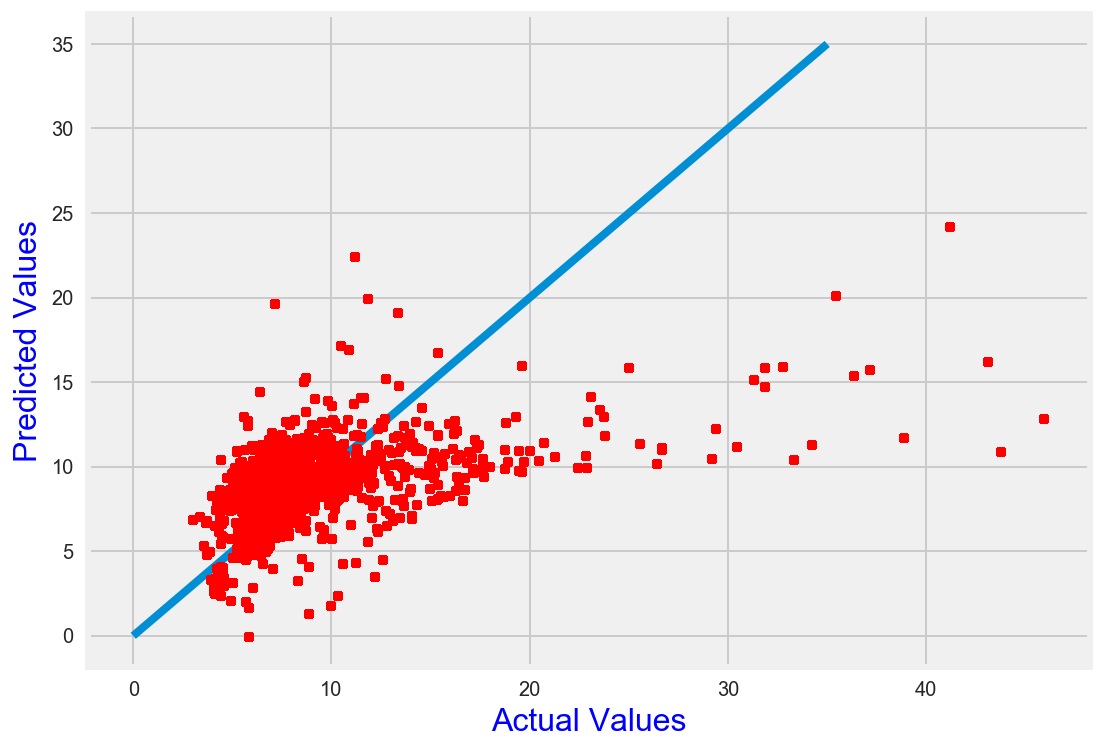

In [64]:
plt.figure(figsize=(8,6))
plt.scatter(y_fe2, predictions_2, s=30, c='r', marker='+', zorder=10)
plt.ylabel("Predicted Values", size=16, color='blue')
plt.xlabel("Actual Values", size=16, color='blue')
p1, p2 = [0,35], [0,35]
plt.plot(p1,p2)
plt.show()

#### <span style='color:midnightblue'> Not surprisingly, since there is so much difference in individual drivers, the regression without them performs much more poorly. It has a low R-squared score, and the ray being on is not significant. </span>

#### <span style='color:midnightblue'> Another way of testing whether a variable is useful in a model is to compare the root mean squared error (RMSE) of the model with and without the variable. </span>

In [221]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_fe2, y_fe2, random_state=1)

lm2 = LinearRegression()
model2 = lm2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

3.38141543175


In [222]:
X_fe2.drop('ray_is_on', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_fe2, y_fe2, random_state=1)

lm2 = LinearRegression()
model2 = lm2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

3.3832332297


#### <span style='color:midnightblue'> There was a tiny increase of 0.0018 in the RMSE when the ray_on variable is removed, suggesting that the effect of having the ray on is inconsequential. </span>

#### <span style='color:midnightblue'> I'm going to return to the matter of potential outliers that I commented on in the exploratory data analysis and take a look at the trip distance plotted against the fuel economy. </span>

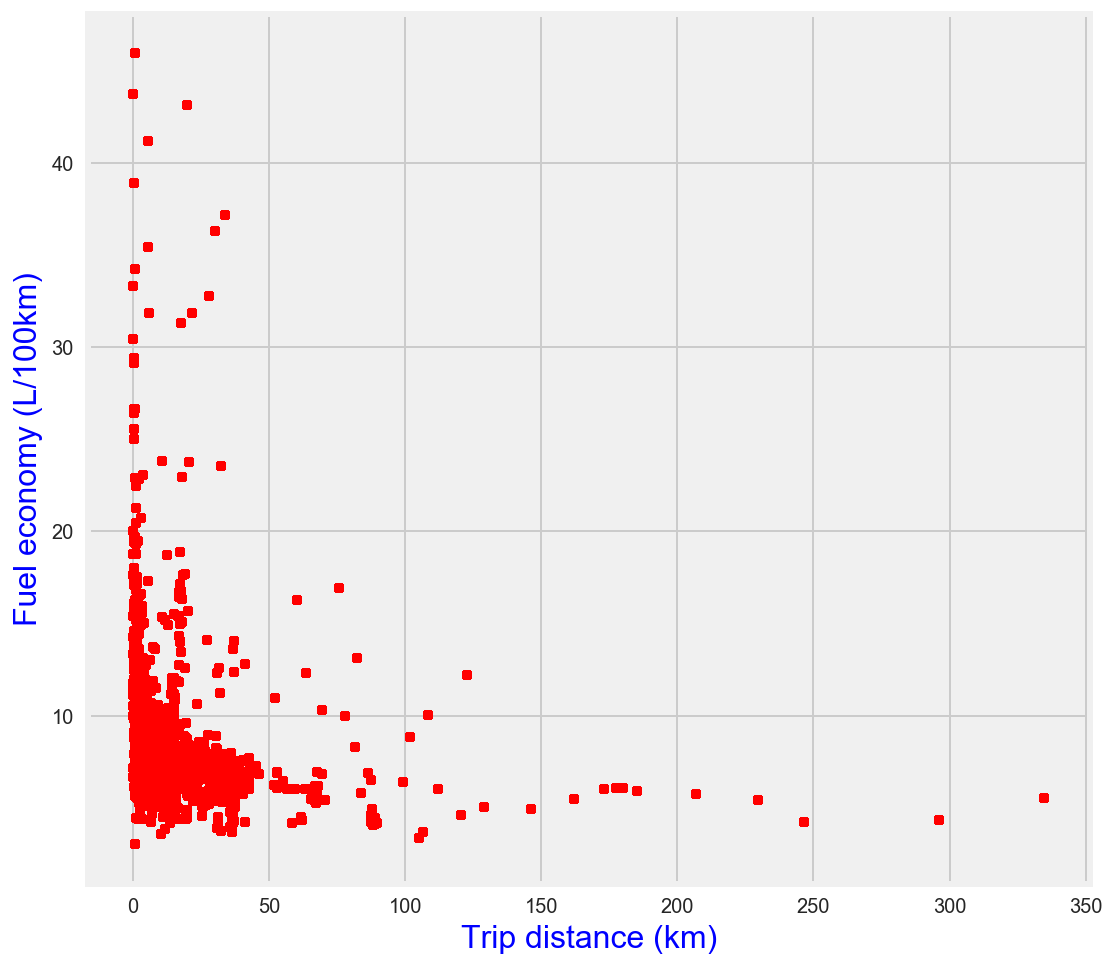

In [65]:
plt.figure(figsize=(8,8))
plt.scatter(summ_trip.trip_dist, summ_trip.fuel_econ, s=30, c='r', marker='+')
plt.xlabel("Trip distance (km)", size = 16, color='blue')
plt.ylabel("Fuel economy (L/100km)", size = 16, color='blue')
plt.show()

#### <span style='color:midnightblue'> The range of fuel economies is much larger when the trip distance is very low. This could be because a minute spent idling at a set of traffic lights might make a relatively large difference to the fuel economy of a short trip, while hardly affecting a longer one. Considering there is little chance for behaviour to affect fuel economy for short drives, I'm going to try analysing the data for trips above 20km. </span> 

In [101]:
summ_trip_20 = summ_trip[summ_trip.trip_dist > 20.0]
summ_trip_20.reset_index(drop=True, inplace=True)
t_test = stats.ttest_ind(summ_trip_20[summ_trip_20.ray_on == 1].fuel_econ, summ_trip_20[summ_trip_20.ray_on == 0].fuel_econ)
t_test

Ttest_indResult(statistic=-1.9709189723680229, pvalue=0.049498814596813143)

#### <span style='color:midnightblue'> A t-test on the trips above 20km is less conclusive than before, but still indicates that there is a difference at the 5% significance level. However, this could still be due to factors other than the Ray being on. </span>

#### <span style='color:midnightblue'> I'll run the individual t-tests again too, but I'll need to check first which drivers still have trips with both the ray on and off, now that a lot have been excluded. </span>

In [160]:
summ_trip_20.groupby('driver_id').ray_on.value_counts()

driver_id  ray_on
1          0         31
           1         27
11         1          9
           0          1
12         1         12
           0         11
13         1          1
14         0         32
           1         22
15         1         22
           0         14
16         1          5
           0          4
18         1         15
           0          4
19         1          8
           0          6
21         0         20
           1          7
22         0         26
           1          6
3          1         13
           0         11
5          0          5
6          0         31
           1         10
7          1          2
8          1          5
           0          1
9          0          1
Name: ray_on, dtype: int64

In [102]:
ttf20_table = pd.DataFrame()
for i in ('1','12','14','15','16','18','19','21','22','3','6'):
    ttf20_table.loc[i, 'Driver'] = i
    ttf20_table.loc[i, 'Ray_on_trips'] = len(summ_trip_20[(summ_trip_20.ray_on == 1) & (summ_trip_20.driver_id == i)])
    ttf20_table.loc[i, 'Ray_off_trips'] = len(summ_trip_20[(summ_trip_20.ray_on == 0) & (summ_trip_20.driver_id == i)])
    ttf20_table.loc[i, 'Ray_on_time_avg'] = round((summ_trip_20[(summ_trip_20.ray_on == 1) & (summ_trip_20.driver_id == i)].
                                           trip_time.mean() / 60),2)
    ttf20_table.loc[i, 'Ray_off_time_avg'] = round((summ_trip_20[(summ_trip_20.ray_on == 0) & (summ_trip_20.driver_id == i)].
                                           trip_time.mean() / 60),2)
    ttf20_table.loc[i, 'Ray_on_fuel_econ'] = round((summ_trip_20[(summ_trip_20.ray_on == 1) & (summ_trip_20.driver_id == i)].
        fuel_used.sum() / summ_trip_20[(summ_trip_20.ray_on == 1) & (summ_trip_20.driver_id == i)].trip_dist.sum()) * 100 ,2)
    ttf20_table.loc[i, 'Ray_off_fuel_econ'] = round((summ_trip_20[(summ_trip_20.ray_on == 0) & (summ_trip_20.driver_id == i)].
        fuel_used.sum() / summ_trip_20[(summ_trip_20.ray_on == 0) & (summ_trip_20.driver_id == i)].trip_dist.sum()) * 100 ,2)
    ray_on_samples = summ_trip_20[(summ_trip_20.ray_on == 1) & (summ_trip_20.driver_id == i)].fuel_econ
    ray_off_samples = summ_trip_20[(summ_trip_20.ray_on == 0) & (summ_trip_20.driver_id == i)].fuel_econ
    t_test = stats.ttest_ind(ray_on_samples, ray_off_samples)
    ttf20_table.loc[i, 't-stat'] = round(t_test[0],3)
    ttf20_table.loc[i, 'p-value'] = round(t_test[1],3)
    
ttf20_table.reset_index(drop=True, inplace=True)

In [103]:
def show_p_vals(val, max=0.05, color='lightgreen'):
    if val <= max:
        return 'background-color: %s' % color
    else:
        return ''

ttf20_table.style.applymap(show_p_vals, subset=['p-value'])

#### <span style='color:midnightblue'> This shows there's a statistically significant difference in fuel economy for drivers 12, 14, 15 and 3. </span>

#### <span style='color:midnightblue'> Driver 7 was one of the three for whom the original t-test (with all the data) showed that the ray was significant. I'll do a regression for this driver with all data and see whether it agrees.  </span>

In [69]:
tdf_cols = ['trip_dist', 'trip_ave_speed', 'trip_rpm', 'brake_rate', 'friday', 'monday', 'saturday', 'thursday', 
            'tuesday', 'wednesday', 'ray_on', 'afternoon_peak', 'between_peak', 'morning_peak', 'driver_id']

In [72]:
X_7 = time_df[tdf_cols]
X_7 = X_7[X_7['driver_id'] == 7]      # Only data for driver 7
del X_7['driver_id']
X_7c = sm.add_constant(X_7)     # statsmodel doesn't fit the intercept by default, so a constant needs to be added

y_7 = time_df[time_df['driver_id'] == 7].fuel_econ.values

In [73]:
model = sm.OLS(y_7, X_7c)
model = model.fit()
predictions = model.predict()

print ("MSE:", mean_squared_error(y_7, predictions))
print ("RMSE:", np.sqrt(mean_squared_error(y_7, predictions)))

model.summary()

MSE: 0.600990918911
RMSE: 0.775236040771


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     25.56
Date:                Tue, 06 Jun 2017   Prob (F-statistic):           5.78e-24
Time:                        01:27:17   Log-Likelihood:                -111.78
No. Observations:                  96   AIC:                             253.6
Df Residuals:                      81   BIC:                             292.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             11.8531      2.306      5.141      0.000         7.265    16.441
trip_dist          0.0050      0.020      0.250      0.803        -0.035     0.045
trip_ave_speed    -0.2725      0.036     -7.612      0.000        -0.344    -0.201
trip_rpm           0.0030      0.002      1.355      0.179        -0.001     0.007
brake_rate        -0.0108      0.005     -2.128      0.036        -0.021    -0.001
friday             0.4271      0.503      0.849      0.398        -0.573     1.427
monday             0.6512      0.530      1.228      0.223        -0.404     1.706
saturday           0.7523      0.506      1.488      0.141        -0.254     1.758
thursday           0.8652      0.493      1.754      0.083        -0.116     1.847
tuesday            0.5172      0.507      1.020      0.311        -0.491     1.526
wednesday          0.8885      0.540      1.645      0.104        -0.186     1.963
ray_on            -0.0488      0.200     -0.243      0.808        -0.447     0.350
afternoon_peak    -0.4656      0.404     -1.152      0.253        -1.270     0.339
between_peak      -0.3026      0.434     -0.697      0.488        -1.166     0.561
morning_peak      -0.4759      0.449     -1.059      0.293        -1.370     0.418
==============================================================================
Omnibus:                        2.042   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.360   Jarque-Bera (JB):                1.437
Skew:                           0.215   Prob(JB):                        0.487
Kurtosis:                       3.418   Cond. No.                     3.74e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### <span style='color:midnightblue'> Although the adjusted R-squared for the model is high, at 0.784, with a p-value of 0.808, the Ray being on is certainly not significant! Just to be sure, I'll run the model again without this variable. </span>

In [75]:
del X_7c['ray_on']

model = sm.OLS(y_7, X_7c)
model = model.fit()
predictions = model.predict()

#X_7['predictions'] = predictions
#X_7['residuals'] = y_7 - X_7['predictions']

print ("MSE:", mean_squared_error(y_7, predictions))
print ("RMSE:", np.sqrt(mean_squared_error(y_7, predictions)))

model.summary()

MSE: 0.601430835709
RMSE: 0.775519719742


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     27.85
Date:                Tue, 06 Jun 2017   Prob (F-statistic):           1.10e-24
Time:                        01:29:33   Log-Likelihood:                -111.81
No. Observations:                  96   AIC:                             251.6
Df Residuals:                      82   BIC:                             287.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             11.8184      2.288      5.165      0.000         7.267    16.370
trip_dist          0.0040      0.019      0.204      0.839        -0.035     0.043
trip_ave_speed    -0.2730      0.036     -7.688      0.000        -0.344    -0.202
trip_rpm           0.0030      0.002      1.372      0.174        -0.001     0.007
brake_rate        -0.0107      0.005     -2.128      0.036        -0.021    -0.001
friday             0.4272      0.500      0.855      0.395        -0.567     1.422
monday             0.6550      0.527      1.243      0.217        -0.393     1.703
saturday           0.7578      0.502      1.509      0.135        -0.241     1.757
thursday           0.8753      0.489      1.791      0.077        -0.097     1.848
tuesday            0.5338      0.499      1.069      0.288        -0.460     1.527
wednesday          0.9087      0.531      1.712      0.091        -0.147     1.965
afternoon_peak    -0.4619      0.402     -1.150      0.254        -1.261     0.337
between_peak      -0.2871      0.427     -0.673      0.503        -1.136     0.562
morning_peak      -0.4774      0.447     -1.069      0.288        -1.366     0.411
==============================================================================
Omnibus:                        1.902   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.309
Skew:                           0.200   Prob(JB):                        0.520
Kurtosis:                       3.409   Cond. No.                     3.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### <span style='color:midnightblue'> As expected, the model output has hardly changed. The adjusted R-squared has risen slightly to 0.786, suggesting that the ray_on variable was not contributing to the model. </span>

#### <span style='color:midnightblue'>  Now I'll check the model for driver 15, first using all the data, then just that for trips over 20km. In the t-tests, driver 15 showed as having a significant difference between Ray on and off means for both all data and just that over 20km. </span>

In [77]:
X_15 = time_df[tdf_cols]
X_15 = X_15[X_15['driver_id'] == 15]
del X_15['driver_id']
X_15c = sm.add_constant(X_15)     # statsmodel doesn't fit the intercept by default, so a constant needs to be added

y_15 = time_df[time_df['driver_id'] == 15].fuel_econ.values

model = sm.OLS(y_15, X_15c)
model = model.fit()
predictions = model.predict()

print ("MSE:", mean_squared_error(y_15, predictions))
print ("RMSE:", np.sqrt(mean_squared_error(y_15, predictions)))

model.summary()

MSE: 8.09299406126
RMSE: 2.84481880992


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     11.66
Date:                Tue, 06 Jun 2017   Prob (F-statistic):           1.09e-13
Time:                        01:31:42   Log-Likelihood:                -221.80
No. Observations:                  90   AIC:                             473.6
Df Residuals:                      75   BIC:                             511.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             38.2011      7.414      5.152      0.000        23.431    52.971
trip_dist          0.0084      0.039      0.214      0.831        -0.070     0.087
trip_ave_speed    -0.1514      0.107     -1.415      0.161        -0.365     0.062
trip_rpm          -0.0174      0.007     -2.383      0.020        -0.032    -0.003
brake_rate        -0.0037      0.006     -0.588      0.558        -0.016     0.009
friday            -0.7081      1.343     -0.527      0.600        -3.384     1.968
monday             0.9662      1.282      0.753      0.454        -1.589     3.521
saturday           2.1998      1.138      1.933      0.057        -0.067     4.467
thursday           1.0048      1.337      0.751      0.455        -1.659     3.669
tuesday           -0.7483      1.321     -0.567      0.573        -3.379     1.882
wednesday          0.2388      1.444      0.165      0.869        -2.638     3.115
ray_on            -0.1858      0.718     -0.259      0.797        -1.617     1.245
afternoon_peak     0.7942      1.551      0.512      0.610        -2.295     3.883
between_peak      -0.4656      1.460     -0.319      0.751        -3.374     2.442
morning_peak       1.9336      1.594      1.213      0.229        -1.242     5.109
==============================================================================
Omnibus:                      100.943   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1773.031
Skew:                           3.483   Prob(JB):                         0.00
Kurtosis:                      23.598   Cond. No.                     3.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### <span style='color:midnightblue'> This model output is no better as far as the ray is concerned! I'll try the data over 20km. </span>

In [78]:
X_15_20km = time_df[time_df.trip_dist > 20.0][tdf_cols]
X_15_20km = X_15_20km[X_15_20km['driver_id'] == 15]
del X_15_20km['driver_id']
X_15_20km_c = sm.add_constant(X_15_20km)     # Adding the constant

y_15_20km = time_df[(time_df['driver_id'] == 15) & (time_df.trip_dist > 20.0)].fuel_econ.values

model = sm.OLS(y_15_20km, X_15_20km_c)
model = model.fit()
predictions = model.predict()

print ("MSE:", mean_squared_error(y_15_20km, predictions))
print ("RMSE:", np.sqrt(mean_squared_error(y_15_20km, predictions)))

model.summary()

MSE: 0.0222462037493
RMSE: 0.149151613298


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     14.31
Date:                Tue, 06 Jun 2017   Prob (F-statistic):           7.88e-08
Time:                        01:32:50   Log-Likelihood:                 17.419
No. Observations:                  36   AIC:                            -6.837
Df Residuals:                      22   BIC:                             15.33
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              7.0158      1.051      6.676      0.000         4.836     9.195
trip_dist          0.0045      0.009      0.523      0.606        -0.013     0.023
trip_ave_speed    -0.0699      0.014     -5.164      0.000        -0.098    -0.042
trip_rpm           0.0002      0.001      0.182      0.857        -0.002     0.003
brake_rate        -0.0020      0.004     -0.455      0.653        -0.011     0.007
friday             0.0499      0.206      0.242      0.811        -0.377     0.477
monday             0.0869      0.179      0.487      0.631        -0.283     0.457
saturday           0.4781      0.289      1.652      0.113        -0.122     1.078
thursday           0.2791      0.185      1.509      0.145        -0.104     0.663
tuesday            0.3127      0.179      1.746      0.095        -0.059     0.684
wednesday          0.2486      0.178      1.396      0.177        -0.121     0.618
ray_on            -0.0125      0.082     -0.153      0.880        -0.182     0.157
afternoon_peak     2.4532      0.362      6.781      0.000         1.703     3.203
between_peak       2.1568      0.351      6.137      0.000         1.428     2.886
morning_peak       2.4058      0.370      6.509      0.000         1.639     3.172
==============================================================================
Omnibus:                        2.159   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                1.089
Skew:                           0.204   Prob(JB):                        0.580
Kurtosis:                       3.748   Cond. No.                     2.47e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.29e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <span style='color:midnightblue'> Once again, while the model adjusted R-squared is quite high, it's showing that the ray has no significant effect. </span>

#### <span style='color:midnightblue'> In all these models, I've not used the three variables xaxisacceleration, yaxisacceleration and zaxisgyroscope. It's difficult to know how to incorporate them when the fuel economy needs to be calculated over a whole trip, whereas it would be small changes in the three variables from one measurement to the next that would have an effect on fuel economy, if any. </span>

#### <span style='color:midnightblue'> To try to include their effect in a model, I will calculate the absolute difference (so that positives and negatives don't cancel out) between each record and the next in a trip, then find the mean for the whole trip. In addition, I will square the xaxisacceleration and take the mean of that for the trip. This is to give extra weight to xaxisacceleration scores on the margins, as they are the ones that we really want to pinpoint. </span>

#### <span style='color:midnightblue'> I will limit the data to just driver 15. </span>

In [79]:
# drive_15 = pd.read_csv('../drive_15.csv')

In [245]:
drive_15 = drive[drive.driver_id == '15']

In [ ]:
drive_15.loc[0, 'delta_x'] = 0
drive_15.loc[0, 'delta_y'] = 0
drive_15.loc[0, 'delta_z'] = 0

for i in range(1, len(drive_15)):
    if drive_15.tripid[i] != drive_15.tripid[i-1]:
        drive_15.loc[i, 'delta_x'] = 0
        drive_15.loc[i, 'delta_y'] = 0
        drive_15.loc[i, 'delta_z'] = 0
    else:
        drive_15.loc[i, 'delta_x'] = abs((drive_15.loc[i, 'xaxisacceleration'] - 
                                         drive_15.loc[i-1, 'xaxisacceleration']))
        drive_15.loc[i, 'delta_y'] = abs((drive_15.loc[i, 'yaxisacceleration'] - 
                                         drive_15.loc[i-1, 'yaxisacceleration']))
        drive_15.loc[i, 'delta_z'] = abs((drive_15.loc[i, 'zaxisgyroscope'] - 
                                         drive_15.loc[i-1, 'zaxisgyroscope']))

In [255]:
drive_15.reset_index(drop=True, inplace=True);

In [33]:
for i in range(len(drive_15)):
    drive_15.loc[i, 'accn_score'] = drive_15.loc[i, 'xaxisacceleration']**2

In [36]:
drive_15.head(2)

speed    rpm  distance  liter  xaxisacceleration  yaxisacceleration  \
0    0.0  836.0       0.0    0.0               0.05               0.03   
1    0.0  843.5       0.0    0.0               0.01               0.03   

   zaxisgyroscope  longitude  latitude           timestamp_utc     ...      \
0            7.41        NaN       NaN  2017-03-09 18:54:48+00     ...       
1           -0.70      -4.25     51.72  2017-03-09 18:54:51+00     ...       

                                 tripid ray_connected  driver_id  \
0  ca878750-a691-e514-b3f4-bb5a7ba1fdc6           0.0       15.0   
1  ca878750-a691-e514-b3f4-bb5a7ba1fdc6           0.0       15.0   

             date_time delta_time  calc_dist  delta_x  delta_y  delta_z  \
0  2017-03-09 18:54:48        0.0        0.0     0.00      0.0     0.00   
1  2017-03-09 18:54:51        0.0        0.0     0.04      0.0     8.11   

   accn_score  
0      0.0025  
1      0.0001  

[2 rows x 21 columns]

In [69]:
delta_x_15 = drive_15[drive_15.calc_dist != 0.0].groupby(['driver_id', 'tripid']).delta_x.mean()
delta_y_15 = drive_15[drive_15.calc_dist != 0.0].groupby(['driver_id', 'tripid']).delta_y.mean()
delta_z_15 = drive_15[drive_15.calc_dist != 0.0].groupby(['driver_id', 'tripid']).delta_z.mean()
accn_score_15 = drive_15[drive_15.calc_dist != 0.0].groupby(['driver_id', 'tripid']).accn_score.mean()

In [70]:
X_15_drive_scores = pd.DataFrame({'delta_x_15': delta_x_15, 'delta_y_15': delta_y_15, 'delta_z_15': delta_x_15,
                                 'accn_score_15': accn_score_15})

In [117]:
X_15_drive_scores.head(2)

accn_score_15  delta_x_15  \
driver_id tripid                                                            
15.0      022b23d8-de05-a444-51e9-98478647f487       0.017424    0.066400   
          02e0b0f4-958d-4d0a-d337-bbbe3ebe1996       0.008163    0.045145   

                                                delta_y_15  delta_z_15  
driver_id tripid                                                        
15.0      022b23d8-de05-a444-51e9-98478647f487    0.028800    0.066400  
          02e0b0f4-958d-4d0a-d337-bbbe3ebe1996    0.026214    0.045145

In [118]:
X_15_drive_scores = pd.DataFrame(X_15_drive_scores.to_records())

#### <span style='color:midnightblue'> I'm going to create a dataframe just for driver 15 with day_of_week and time_of_day variables, as created for the regressions above. </span>

In [11]:
summ_trip_15 = summ_trip[summ_trip.driver_id == '15']

In [12]:
time_df_15 = pd.DataFrame()

time_df_15['driver_id'] = summ_trip_15['driver_id']
time_df_15['trip_dist'] = summ_trip_15['trip_dist']
time_df_15['fuel_econ'] = summ_trip_15['fuel_econ']
time_df_15['trip_time'] = summ_trip_15['trip_time']
time_df_15['trip_ave_speed'] = summ_trip_15['trip_ave_speed']
time_df_15['ray_on'] = summ_trip_15['ray_on']
time_df_15['brake_rate'] = summ_trip_15['brake_rate']
time_df_15['trip_rpm'] = summ_trip_15['trip_rpm']
time_df_15['trip_start'] = summ_trip_15['trip_start']
time_df_15['tripid'] = summ_trip_15['tripid']

In [106]:
time_df_15.index

Int64Index([562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574,
            575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587,
            588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600,
            601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613,
            614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626,
            627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639,
            640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651],
           dtype='int64')

In [86]:
time_df_15.reset_index(drop=True, inplace=True)

In [87]:
for i in range(len(time_df_15)):
    time_df_15.loc[i, 'trip_start'] = pd.to_datetime(time_df_15.loc[i, 'trip_start']).to_pydatetime()

In [88]:
time_df_15.ray_on = time_df_15.ray_on.astype(str)
time_df_15.set_index('trip_start', inplace=True)

In [89]:
days_of_week = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'friday', 
                5: 'saturday', 6: 'sunday'}

for i in time_df_15.index:
    time_df_15.loc[i, 'day_of_week'] = days_of_week[i.weekday()]
    time_df_15['day_of_week'].value_counts()

dummy = pd.get_dummies(time_df_15['day_of_week'])
time_df_15 = pd.concat([time_df_15, dummy], axis=1)

In [90]:
for i in time_df_15.index:
    if (i.hour) < 6:
        time_df_15.loc[i, 'time_of_day'] = 'off_peak'
    elif (i.hour) < 10:
        time_df_15.loc[i, 'time_of_day'] = 'morning_peak'
    elif (i.hour) < 15:
        time_df_15.loc[i, 'time_of_day'] = 'between_peak'
    elif (i.hour) < 19:
        time_df_15.loc[i, 'time_of_day'] = 'afternoon_peak'
    else:
        time_df_15.loc[i, 'time_of_day'] = 'off_peak'
        
dummy = pd.get_dummies(time_df_15['time_of_day'])
time_df_15 = pd.concat([time_df_15, dummy], axis=1)

In [91]:
time_df_15.columns

Index(['driver_id', 'trip_dist', 'fuel_econ', 'trip_time', 'trip_ave_speed',
       'ray_on', 'brake_rate', 'trip_rpm', 'tripid', 'day_of_week', 'friday',
       'monday', 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday',
       'time_of_day', 'afternoon_peak', 'between_peak', 'morning_peak',
       'off_peak'],
      dtype='object')

In [92]:
time_df_15 = pd.DataFrame(time_df_15.to_records())

#### <span style='color:midnightblue'> I'll merge this table with the one with the x, y and z axis scores. </span>

In [122]:
X_15_comb = pd.merge(time_df_15, X_15_drive_scores, on = 'tripid')

In [123]:
X_15_comb.head(1)

trip_start driver_id_x  trip_dist  fuel_econ  trip_time  \
0 2017-03-09 18:54:48          15       0.51  19.607843      136.0   

   trip_ave_speed ray_on  brake_rate     trip_rpm  \
0            13.5      0         0.0  1068.102804   

                                 tripid     ...         time_of_day  \
0  ca878750-a691-e514-b3f4-bb5a7ba1fdc6     ...      afternoon_peak   

   afternoon_peak  between_peak  morning_peak  off_peak  driver_id_y  \
0               1             0             0         0         15.0   

   accn_score_15  delta_x_15 delta_y_15  delta_z_15  
0       0.019515    0.073542   0.066042    0.073542  

[1 rows x 28 columns]

In [125]:
del X_15_comb['driver_id_x']
del X_15_comb['driver_id_y']

In [21]:
# X_15_comb = pd.read_csv('../X_15_comb.csv')

#### <span style='color:midnightblue'> Now I'll try a regression again with the new columns included. Once again, I'll just use data for trips longer then 20km. </span>

In [22]:
tdf_cols_15 = list(X_15_comb.columns)
tdf_cols_15.remove('fuel_econ') 
tdf_cols_15.remove('trip_start')
tdf_cols_15.remove('trip_time')
tdf_cols_15.remove('day_of_week')
tdf_cols_15.remove('time_of_day')
tdf_cols_15.remove('sunday')
tdf_cols_15.remove('off_peak')
tdf_cols_15.remove('tripid')

X_15_comb.ray_on = X_15_comb.ray_on.astype('int')

X_15_20 = X_15[X_15.trip_dist > 20]
y_15_20 = time_df_15[time_df_15.trip_dist > 20].fuel_econ.values


In [34]:
X_15_20_c = sm.add_constant(X_15_20)     # Adding a constant

model_15_20 = sm.OLS(y_15_20, X_15_20_c)
model_15_20 = model_15_20.fit()
predictions_15_20 = model_15_20.predict()

print ("MSE:", mean_squared_error(y_15_20, predictions_15_20))
print ("RMSE:", np.sqrt(mean_squared_error(y_15_20, predictions_15_20)))

model_15_20.summary()

MSE: 0.0198120316425
RMSE: 0.140755218882


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     11.42
Date:                Tue, 06 Jun 2017   Prob (F-statistic):           1.44e-06
Time:                        10:00:47   Log-Likelihood:                 19.505
No. Observations:                  36   AIC:                            -5.009
Df Residuals:                      19   BIC:                             21.91
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              7.0226      1.324      5.303      0.000         4.251     9.794
trip_dist          0.0054      0.009      0.601      0.555        -0.013     0.024
trip_ave_speed    -0.0651      0.021     -3.114      0.006        -0.109    -0.021
ray_on            -0.0015      0.092     -0.016      0.987        -0.194     0.191
brake_rate        -0.0066      0.005     -1.208      0.242        -0.018     0.005
trip_rpm        8.988e-05      0.002      0.045      0.965        -0.004     0.004
friday            -0.1348      0.311     -0.434      0.669        -0.785     0.515
monday            -0.1004      0.301     -0.333      0.743        -0.731     0.530
saturday           0.3482      0.306      1.138      0.269        -0.292     0.989
thursday           0.0767      0.314      0.244      0.810        -0.580     0.734
tuesday            0.1220      0.310      0.394      0.698        -0.526     0.770
wednesday          0.0230      0.295      0.078      0.939        -0.594     0.640
afternoon_peak     2.3865      0.465      5.136      0.000         1.414     3.359
between_peak       2.1961      0.456      4.814      0.000         1.241     3.151
morning_peak       2.4399      0.442      5.526      0.000         1.516     3.364
accn_score_15     47.3255     40.563      1.167      0.258       -37.574   132.225
delta_x_15         0.3213      5.548      0.058      0.954       -11.290    11.933
delta_y_15        -9.9430     10.529     -0.944      0.357       -31.980    12.094
delta_z_15         0.3213      5.548      0.058      0.954       -11.290    11.933
==============================================================================
Omnibus:                        1.654   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.437   Jarque-Bera (JB):                0.687
Skew:                          -0.095   Prob(JB):                        0.709
Kurtosis:                       3.649   Cond. No.                     2.75e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.04e-35. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <span style='color:midnightblue'> The R-squared score has increased slightly from the previous model, from 0.894 to 0.906, and the RMSE reduced slightly. However, the adjusted R-squared has decreased from 0.832 to 0.827, and remains noticeably less than the R-squared, which indicates that the x, y, and z variables I added, and probably others in the model, are not contributing. In fact, the only independent variables that are showing as being significant at the 5% level are the average speed and time of day variables. </span>

#### <span style='color:midnightblue'> I could try other tweaks to the linear regression models, but I will take a look at a few other things to see if I can find anything useful. </span> 

### <span style='color:royalblue'> Principal Components Analysis </span>

#### <span style='color:midnightblue'> In the model above I have 18 variables, with some correlation between them (see below). I'm curious to see what happens if I run a Principal Components Analysis (PCA), to see whether any stand out as contributing heavily. I'll stick with driver 15, and use the data from all trips. </span>

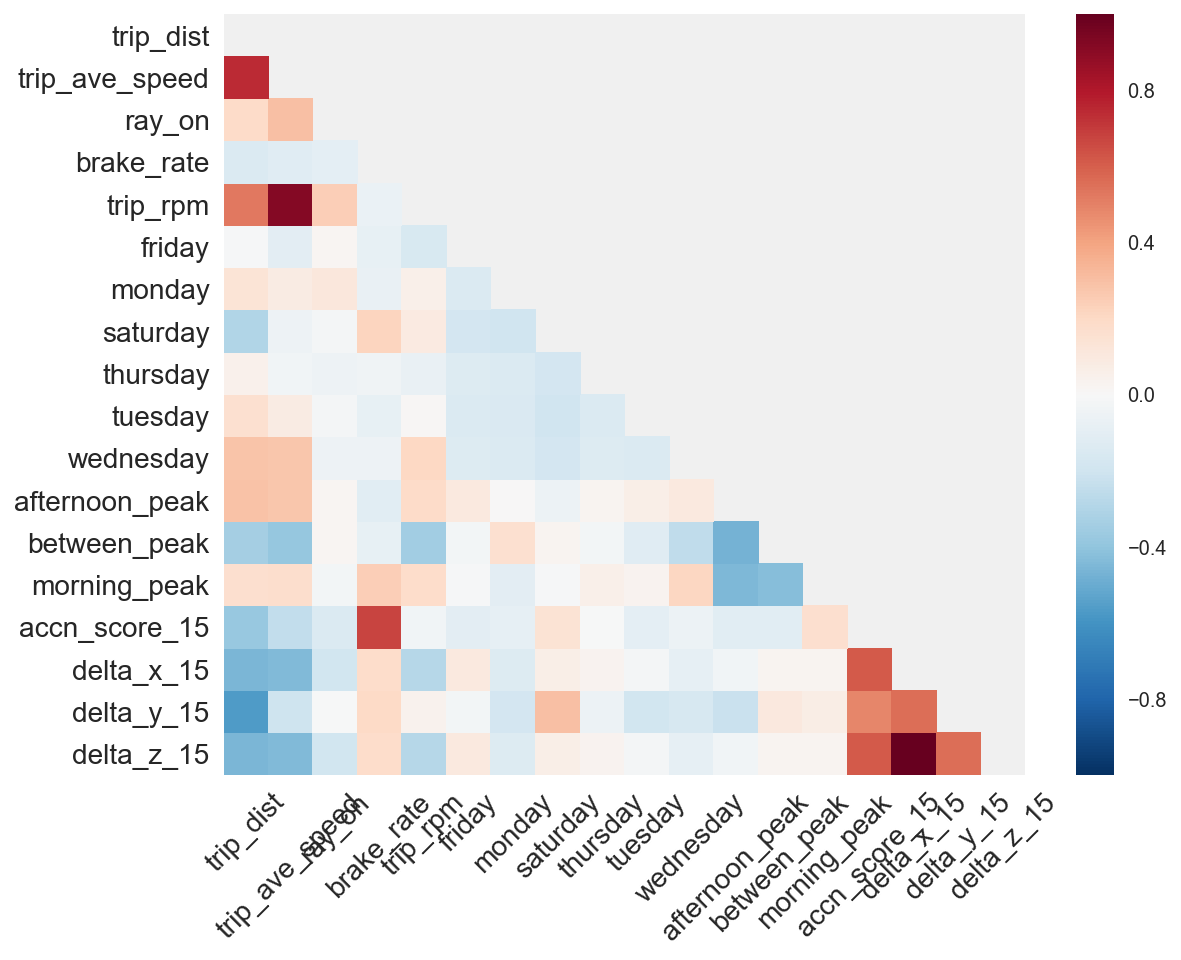

In [99]:
# The following heatmap shows the correlation between variables
X_15_corr = X_15.corr()

mask = np.zeros_like(X_15_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))

ax = sns.heatmap(X_15_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

In [23]:
from sklearn.decomposition import PCA

X15_pca = PCA(n_components=18)
X15_pca.fit(X_15.values)

PCA(copy=True, iterated_power='auto', n_components=18, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X15s = ss.fit_transform(X_15)

In [25]:
X15s_pca = PCA(n_components=18)
X15s_pca.fit(X15s)

PCA(copy=True, iterated_power='auto', n_components=18, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [26]:
X15s_components = X15s_pca.components_

#### <span style='color:midnightblue'> I'll print out the weights of the first six components. </span>

In [27]:
print (tdf_cols_15, '\n')
print ('--------------------------------------------------\n')

for i, pc in enumerate(['PC1','PC2','PC3','PC4','PC5','PC6']):
    print (pc, 'variable weights:', X15s_components[i])
    print( '----------------------------------------------\n')

['trip_dist', 'trip_ave_speed', 'ray_on', 'brake_rate', 'trip_rpm', 'friday', 'monday', 'saturday', 'thursday', 'tuesday', 'wednesday', 'afternoon_peak', 'between_peak', 'morning_peak', 'accn_score_15', 'delta_x_15', 'delta_y_15', 'delta_z_15'] 

--------------------------------------------------

PC1 variable weights: [-0.39403878 -0.37485801 -0.14027203  0.17623581 -0.27660704  0.03089103
 -0.08759225  0.12245799  0.00757345 -0.07130663 -0.14147599 -0.15205333
  0.14663376 -0.01794211  0.31116156  0.38096527  0.31008692  0.38096527]
----------------------------------------------

PC2 variable weights: [ 0.14517986  0.30883758  0.00979691  0.2935828   0.37789198 -0.09852549
 -0.15701981  0.1200341  -0.01673514  0.00313208  0.21944266  0.07743558
 -0.42490387  0.36452213  0.35910497  0.17899778  0.2116237   0.17899778]
----------------------------------------------

PC3 variable weights: [ 0.12431255 -0.09408519 -0.21709783 -0.18748921 -0.18370838  0.29604613
 -0.18505467 -0.38305415  

#### <span style='color:midnightblue'> In the first six principal components, the 'ray_on' variable has co-efficients of -0.14, 0.0098, -0.217, -0.266, -0.318 and 0.116. It is contributing slightly, although not as much as others. </span>

In [149]:
np.cumsum(np.round(X15s_pca.explained_variance_ratio_, decimals=4)*100)

array([  24.12,   37.48,   46.72,   54.86,   61.46,   67.94,   74.27,
         80.4 ,   86.1 ,   90.34,   94.  ,   96.68,   97.97,   98.94,
         99.51,   99.87,  100.01,  100.01])

#### <span style='color:midnightblue'> It takes ten principal components before 90% of the variance is accounted for. I think that this is a good indication that any change in fuel economy is due to a variety of factors and not easily explained. </span>

### <span style='color:royalblue'> Ray on variable </span>

#### <span style='color:midnightblue'> To conclude, I'll try making the 'ray_on' variable, i.e. is the Ray on or off, as the dependent variable. I'll set up a new DataFrame for this. </span>


In [55]:
ray_df = pd.DataFrame()

ray_df['driver_id'] = summ_trip['driver_id']
ray_df['trip_dist'] = summ_trip['trip_dist']
ray_df['fuel_econ'] = summ_trip['fuel_econ']
ray_df['trip_time'] = summ_trip['trip_time']
ray_df['trip_ave_speed'] = summ_trip['trip_ave_speed']
ray_df['ray_on'] = summ_trip['ray_on']
ray_df['trip_start'] = summ_trip['trip_start']
ray_df['brake_rate'] = summ_trip['brake_rate']
for i in range(len(ray_df)):
    ray_df.loc[i, 'trip_start'] = pd.to_datetime(ray_df.loc[i, 'trip_start']).to_pydatetime()
ray_df.ray_on = ray_df.ray_on.astype(str)
ray_df.set_index('trip_start', inplace=True)

#ray_df.to_csv('./ray_df.csv')

In [56]:
days_of_week = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'friday', 
                5: 'saturday', 6: 'sunday'}

for i in ray_df.index:
    ray_df.loc[i, 'day_of_week'] = days_of_week[i.weekday()]
print (ray_df.groupby('day_of_week').ray_on.value_counts())

dummy = pd.get_dummies(ray_df['day_of_week'])
ray_df = pd.concat([ray_df, dummy], axis=1)

day_of_week  ray_on
friday       0         124
             1         102
monday       0         108
             1          60
saturday     0         112
             1          91
sunday       0          95
             1          60
thursday     0         119
             1          89
tuesday      0         122
             1          68
wednesday    0         108
             1          89
Name: ray_on, dtype: int64


In [57]:
for i in ray_df.index:
    if (i.hour) < 6:
        ray_df.loc[i, 'time_of_day'] = 'off_peak'
    elif (i.hour) < 10:
        ray_df.loc[i, 'time_of_day'] = 'morning_peak'
    elif (i.hour) < 15:
        ray_df.loc[i, 'time_of_day'] = 'between_peak'
    elif (i.hour) < 19:
        ray_df.loc[i, 'time_of_day'] = 'afternoon_peak'
    else:
        ray_df.loc[i, 'time_of_day'] = 'off_peak'

dummy = pd.get_dummies(ray_df['time_of_day'])
ray_df = pd.concat([ray_df, dummy], axis=1)

In [58]:
ray_df = pd.DataFrame(ray_df.to_records())
print (ray_df.head(2))

           trip_start driver_id  trip_dist  fuel_econ  trip_time  \
0 2017-03-08 06:33:31         1      88.05   4.486087     4349.0   
1 2017-03-08 18:37:33         1      88.94   4.306274     4047.0   

   trip_ave_speed ray_on  brake_rate day_of_week  friday    ...     saturday  \
0       72.885721      0    0.000000   wednesday       0    ...            0   
1       79.116383      0    1.124353   wednesday       0    ...            0   

   sunday  thursday  tuesday  wednesday     time_of_day afternoon_peak  \
0       0         0        0          1    morning_peak              0   
1       0         0        0          1  afternoon_peak              1   

   between_peak  morning_peak  off_peak  
0             0             1         0  
1             0             0         0  

[2 rows x 21 columns]


### <span style='color:royalblue'> k Nearest Neighbours </span>

#### <span style='color:midnightblue'> I'm going to try knn again to see how it goes with predicting whether the ray is on or off for a trip. I'm going to do this for individual drivers. </span>

In [59]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

rdf_cols = list(ray_df.columns)
rdf_cols.remove('ray_on') 
rdf_cols.remove('trip_start')
rdf_cols.remove('trip_time')
rdf_cols.remove('day_of_week')
rdf_cols.remove('time_of_day')
#rdf_cols.remove('sunday')
#rdf_cols.remove('off_peak')

X7_ray = ray_df[rdf_cols]
X7_ray = X7_ray[X7_ray['driver_id'] == '7']
del X7_ray['driver_id']
X7_ray.sample(frac=1)                       # This randomly sorts the dataframe, to improve the train-test split
X7_ray_s = ss.fit_transform(X7_ray)

y7_ray = ray_df[ray_df['driver_id'] == '7'].ray_on.values

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### <span style='color:midnightblue'> I'll just split the data into half to train and test it, since I don't have a lot of trips. </span>

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X7_ray_s, y7_ray, random_state=5, test_size=0.5)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

#### <span style='color:midnightblue'> I'll see how the classification goes for just driver 7 first, using a k of 5. </span>

In [61]:
print (y7_ray)
print (y_train)
print (y_test)

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1']
['0' '1' '1' '1' '0' '1' '0' '0' '1' '0' '1' '0' '0' '1' '0' '1' '0' '0'
 '0' '1' '0' '1' '0' '1' '0' '0' '0' '1' '0' '1' '1' '1' '0' '1' '1' '0'
 '0' '1' '0' '1' '0' '0' '1' '0' '1' '0' '1' '1']
['0' '1' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '0' '1'
 '0' '1' '1' '0' '0' '0' '1' '1' '0' '1' '0' '1' '0' '0' '1' '1' '1' '0'
 '0' '0' '0' '1' '0' '1' '0' '1' '0' '0' '0' '1']


In [62]:
y_pred = knn.predict(X_test)
print ('knn score is: ',metrics.accuracy_score(y_test, y_pred))
print ('Baseline is: ', len(y7_ray[y7_ray == '0']) / len(y7_ray))

knn score is:  0.541666666667
Baseline is:  0.5833333333333334


#### <span style='color:midnightblue'> The result was worse than the baseline! </span>

#### <span style='color:midnightblue'> Now I'll run it for the other drivers. I'll iterate over k-values up to the size of the training set and see which gives the highest score. </span>

In [63]:
#knn_cols = ['driver_id', 'knn_score', 'baseline']
#df_knn = df_knn[knn_cols]
df_knn = pd.DataFrame()
df_knn['driver_id'] = (summ_trip['driver_id'].unique())

In [64]:
ray_df.columns

Index(['trip_start', 'driver_id', 'trip_dist', 'fuel_econ', 'trip_time',
       'trip_ave_speed', 'ray_on', 'brake_rate', 'day_of_week', 'friday',
       'monday', 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday',
       'time_of_day', 'afternoon_peak', 'between_peak', 'morning_peak',
       'off_peak'],
      dtype='object')

In [65]:
from sklearn.preprocessing import StandardScaler

for i in range(len(df_knn)):
    knn_test = 0.
    k_number = 0
    
    driver = df_knn.loc[i, 'driver_id']
    rdf_cols = list(ray_df.columns)
    rdf_cols.remove('ray_on') 
    rdf_cols.remove('trip_start')
    rdf_cols.remove('trip_time')
    rdf_cols.remove('day_of_week')
    rdf_cols.remove('time_of_day')

    X = ray_df[rdf_cols]
    X = X[X['driver_id'] == driver]
    del X['driver_id']
    X = X.sample(frac=1)
    
    ss = StandardScaler()
    Xs = ss.fit_transform(X)
    
    y = ray_df[ray_df['driver_id'] == driver].ray_on.values

    X_train, X_test, y_train, y_test = train_test_split(Xs, y, random_state=99, test_size=0.5)
    
    if len(y[y == '0']) > len(y[y == '1']):
        df_knn.loc[i, 'baseline'] = len(y[y == '0']) / len(y)
    else:
        df_knn.loc[i, 'baseline'] = len(y[y == '1']) / len(y)

    for j in range (1, len(X_test)):
        knn = KNeighborsClassifier(n_neighbors=j)
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        if metrics.accuracy_score(y_test, y_pred) > knn_test:
            knn_test = metrics.accuracy_score(y_test, y_pred)
            k_number = j
    
    df_knn.loc[i, 'k_number'] = k_number
    df_knn.loc[i, 'knn_score'] = knn_test
    df_knn.loc[i, 'result'] = df_knn.loc[i, 'knn_score'] - df_knn.loc[i, 'baseline']

In [66]:
from IPython.display import display, HTML
df_knn = df_knn.sort_values(by = 'result', ascending = False)
display(HTML(df_knn.to_html(index=False)))

#### <span style='color:midnightblue'> It looks like we have a decent chance of prediction for some of the drivers. However, I think that with the low number of trips available, it could be chance as much as anything. I'd want to test with a larger dataset before coming to any conclusions. </span>

### <span style='color:royalblue'> Logistic Regression </span>

#### <span style='color:midnightblue'> I'll build a logistic regression model for predicting if the Ray is on or off and see if the fuel economy is an important feature. </span>

In [72]:
log_cols = list(ray_df.columns) 
log_cols.remove('trip_start')
log_cols.remove('trip_time')
log_cols.remove('day_of_week')
log_cols.remove('time_of_day')
log_cols.remove('sunday')
log_cols.remove('off_peak')
print (log_cols)

['driver_id', 'trip_dist', 'fuel_econ', 'trip_ave_speed', 'ray_on', 'brake_rate', 'friday', 'monday', 'saturday', 'thursday', 'tuesday', 'wednesday', 'afternoon_peak', 'between_peak', 'morning_peak']


In [85]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

df_log = ray_df[log_cols]
df_log['ray_on'] = df_log['ray_on'].astype('int')

ray_model = smf.logit("ray_on ~ trip_dist + fuel_econ + trip_ave_speed + brake_rate + friday + monday + saturday + "
        "thursday + tuesday + wednesday + afternoon_peak + between_peak + morning_peak", data=df_log).fit()
ray_model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Optimization terminated successfully.
         Current function value: 0.666316
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 ray_on   No. Observations:                 1347
Model:                          Logit   Df Residuals:                     1333
Method:                           MLE   Df Model:                           13
Date:                Tue, 06 Jun 2017   Pseudo R-squ.:                 0.01814
Time:                        11:55:07   Log-Likelihood:                -897.53
converged:                       True   LL-Null:                       -914.11
                                        LLR p-value:                  0.001611
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -0.1668      0.335     -0.498      0.618        -0.823     0.489
trip_dist         -0.0024      0.003     -0.818      0.413        -0.008     0.003
fuel_econ         -0.0325      0.015     -2.121      0.034        -0.062    -0.002
trip_ave_speed     0.0088      0.005      1.876      0.061        -0.000     0.018
brake_rate         0.0001      0.001      0.142      0.887        -0.002     0.002
friday             0.2901      0.218      1.329      0.184        -0.138     0.718
monday            -0.1780      0.237     -0.750      0.453        -0.643     0.287
saturday           0.2471      0.221      1.119      0.263        -0.186     0.680
thursday           0.1346      0.226      0.594      0.552        -0.309     0.578
tuesday           -0.2168      0.235     -0.924      0.356        -0.677     0.243
wednesday          0.2506      0.231      1.085      0.278        -0.202     0.703
afternoon_peak    -0.2112      0.179     -1.183      0.237        -0.561     0.139
between_peak      -0.2197      0.199     -1.103      0.270        -0.610     0.171
morning_peak      -0.5475      0.193     -2.841      0.004        -0.925    -0.170
==================================================================================
"""

#### <span style='color:midnightblue'> With more time, I'd test this model to see how accurate it's  predictions are. However, all I can see from it at this point is that the fuel economy is a significant factor in the model, with a p-value of 0.034. </span>

### <span style='color:royalblue'> SelectKBest Feature Selection </span>

#### <span style='color:midnightblue'> I'll end my experimentation with a quick SelectKBest feature selection analysis, to see what it indicates are important variables. </span>

In [95]:
# Feature selection using SelectKBest
rdf_cols = list(ray_df.columns)
rdf_cols.remove('ray_on') 
rdf_cols.remove('trip_start')
rdf_cols.remove('trip_time')
rdf_cols.remove('day_of_week')
rdf_cols.remove('time_of_day')


X_ray = ray_df[rdf_cols]
y_ray = ray_df.ray_on.values

from sklearn.feature_selection import SelectKBest, chi2, f_classif

skb_f = SelectKBest(f_classif, k=5)
skb_chi2 = SelectKBest(chi2, k=5)

skb_f.fit(X_ray, y_ray)
skb_chi2.fit(X_ray, y_ray)

kbest = pd.DataFrame([rdf_cols, list(skb_f.scores_), list(skb_chi2.scores_)], 
            index=['feature','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)
kbest


feature   f_classif  chi2 score
2        fuel_econ     8.54833     20.0964
14    morning_peak     7.26195     5.43467
3   trip_ave_speed     6.60384     59.7344
15        off_peak     4.68201     4.04829
10         tuesday       2.973      2.5518
6           monday     2.64745     2.31614
5           friday      1.4759     1.22875
1        trip_dist     1.37698      57.972
11       wednesday     1.28509     1.09773
7         saturday     1.08967     0.92608
4       brake_rate     0.89839     181.089
12  afternoon_peak    0.670791    0.418225
0        driver_id    0.599835     2.19409
8           sunday    0.560982    0.496961
9         thursday    0.168076    0.142316
13    between_peak  0.00489576  0.00372368

#### <span style='color:midnightblue'> Once again, it is indicating that the fuel economy is important. </span>

## <span style='color:royalblue'> <u> Discussion </u></span>

<span style='color:midnightblue'> The aim of the analysis was to determine whether there was any observed change in driver behaviour when the Ray was on and providing feedback. The main focus was on the fuel economy, with some analysis done on braking as well. </span>

<span style='color:midnightblue'> A t-test showed that there was a statistically significant difference in the mean fuel economy with the Ray on, when looking at all 19 drivers together. The mean was lower, indicating improved fuel economy, which is given in litres used per 100km. Tests on individual drivers showed that only drivers 3, 7 and 15 had a significant difference at the 5% confidence level, also with improved economy. The number of trips per driver ranged between 15 and 151, while there were 1,347 in total. This small number of samples for some drivers means there would have to be a reasonably large difference in the mean fuel economy for the t-test to indicate it was significant. </span>

<span style='color:midnightblue'> To try to find out more about what was contributing to the difference in means, a number of linear regression models were built. Extra variables for the day of the week and the time of the day were created, to add to the trip distance, average speed, rpm, brake rate and the Ray being on or off. </span>

<span style='color:midnightblue'> A model that included all drivers as individual variables was created. It returned a reasonable R-squared score of 0.686 and a root mean squared error (RMSE) of 2.54. In this model the ray_on variable had a p-value of 0.009, showing that it contributed. The regression was run again, this time removing the drivers as variables from the model. Not surprisingly, since there is so much difference in individual drivers, the regression without them performed much more poorly. However, what I wanted to see was whether the ray_on variable was still significant. It returned a p-value of 0.191, meaning that it wasn't. Its effect was tested further by removing it from the model and running it gain. The RMSE increased slightly by 0.0018, indicating the ray_on was not contributing to the model. </span>

<span style='color:midnightblue'> Up to this point, data for all lengths of trips had been included, some less than 200m. A plot of trip distance versus fuel economy showed that the range of fuel economies was much greater for short trips than for longer ones. This could be because a minute spent idling at a set of traffic lights might make a relatively large difference to the fuel economy of a short trip, while hardly affecting a longer one. Considering there is little chance for behaviour to affect fuel economy for short drives, I decided to try analysing the data for trips above 20km. </span>

<span style='color:midnightblue'> Another t-test was conducted for individual drivers on their mean fuel economy with the Ray on and off. Only 11 out of the 19 had enough data to be included, and 4 of these, drivers 3, 12, 14 and 15, were found to have different means at the 5% level of significance. Three more regressions were run, this time on individual drivers: driver 7 with all data, then driver 15 with all data and with trips over 20km only. Although the models had reasonably high R-squared scores and low RMSE, none of them indicated that the Ray being on contributed significantly. </span>

<span style='color:midnightblue'> One final regression was run for driver 15 for trips over 20km, this time including a measure of the average change in the x, y and z axis variables. The R-squared score increased slightly from the previous model, from 0.894 to 0.906, and the RMSE reduced slightly. However, the adjusted R-squared decreased from 0.832 to 0.827, and remained noticeably less than the R-squared, which indicated that the x, y, and z variables I added, and probably others in the model, were not contributing. In fact, the only independent variables that were showing as being significant at the 5% level were the average speed and time of day variables.</span>

<span style='color:midnightblue'> Towards the end of my analysis, I began looking at other possible avenues for further investigation. One would be to use different methods for trying to determine what variables are significant. I conducted a Principal Components Analysis, which indicated that the Ray may have a small effect amongst a number of other variables. I also looked briefly at whether setting ray_on as the independent variable could be useful. A logistic regression and SelectKBest feature selection on all the data suggested that the fuel economy was significant to determining whether the Ray was on. However, this is not surprising since it really is just the reverse of what the original t-test showed, that the Ray was significant to fuel economy over the whole population. </span>

<span style='color:midnightblue'> Regarding any changes in braking, a t-test only showed two drivers having a change in the mean rate of hard braking with the Ray on, (one being a significant increase!), but I'm not convinced that aggregating this variable over a trip is very useful. I think that analysis of the individual acceleration records would be more fruitful, especially if more complete and accurate latitude and longitude records were available. A k Nearest Neighbours model was used with some success to impute missing latitudes and longitudes, and with some more refining, might produce even better results. </span>


## <span style='color:royalblue'> <u>Conclusion </u></span>

<span style='color:midnightblue'> Although I was attempting to build as good a model for fuel economy as possible, the purpose of this project wasn't to build a model to predict fuel economy accurately. The goal was simply to see whether the regression models indicated that the ray_on variable was significant. That would give some support to say that the driver's behaviour was being affected by the Ray. I believe that there is some evidence to support this, but it is inconclusive. Because each driver is driving a different vehicle, in different areas and at different times, I am not willing to draw any conclusions from the aggregated data, as the effect of the Ray would be minor compared to these other variables. For individual drivers, even when there seems to be a difference in fuel economy, the models are not showing that the Ray being on is a strong contributor. </span>

<span style='color:midnightblue'> I think that, for further analysis, investigating individual drivers, rather than groups of drivers, would be most beneficial. It is easier to prove a change of behaviour and, after all, the focus is to convince individuals, or maybe fleet managers, to buy the device. The goal isn't to prove change at the population level, which might be required if trying to get government to make a change to a law, for example. As always, more data would be beneficial. This analysis was done with only approximately four weeks' data, which is two weeks with the Ray on and two with it off. </span>

<span style='color:midnightblue'> Dealing with human behaviour also introduces other considerations. It is entirely possible that some of the drivers changed behaviour even without the Ray being connected, as just knowing that data was being collected made them focus on how they were driving in any case. If data were recorded for long enough, some sort of time series analysis could even be conducted, to see whether any effect changed over a longer period. Optimally, this would be conducted over the same route, such as driving to and from work. </span>

<span style='color:midnightblue'> The thought occurred to me that with driverless cars most likely being the way of the future, that the requirement for this device might not be around for more than a decade or two. However, it could also be that there are other uses for it. I recall reading about some crashes involving tests with driverless cars, caused by the cars stopping at orange lights, when the drivers behind weren't expecting it. People drive differently in different countries and even cities - perhaps there's a market to collect information about driving behaviour, to help prepare for the day when people no longer drive at all! </span>